# Quick visualisations of the data

<b>First we should pip install the below modules if we haven't already </b>

In [1]:
#!pip install wordcloud
#!pip install google-cloud-storage
#!pip install gcsfs
#!pip install wordsegment

<b>Importing dependencies </b>

In [1]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import os
import pandas as pd
import re
import json
import html
import wordsegment as ws
from wordsegment import load, segment
import seaborn as sns

<b> Testing if we have GCS bucket access... </b>

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= "C:/Users/fionn/Downloads/storageCreds.json"
from google.cloud import storage
storage_client = storage.Client()
buckets = list(storage_client.list_buckets())
print("If access granted, below will print \"[<Bucket: csc3002>]\"")
print(buckets) # Testing if access to GCS has been granted

pd.set_option('display.max_colwidth', -1) # Set col width to -1 so we can see entire text column

If access granted, below will print "[<Bucket: csc3002>]"
[<Bucket: csc3002>]


## Visualising HatEval Dataset
<b> Loading in training data for HatEval </b>

In [4]:
train = pd.read_csv('Raw_Data/hateval2019/hateval2019_en_train.csv', sep=',',  index_col = False, encoding = 'utf-8')
dev =  pd.read_csv('Raw_Data/hateval2019/hateval2019_en_dev.csv', sep=',',  index_col = False, encoding = 'utf-8')
frames = [train,dev]
data = pd.concat(frames)
data.rename(columns={'text': 'tweet', 'HS': 'label'}, inplace=True)
cols = ['TR', 'AG']
data.drop(cols, inplace = True, axis = 1)

data.loc[data['label'] == 0, 'label'] = "Not Hate"
data.loc[data['label'] == 1, 'label'] = "Hate"
data.head()

id  \
0  201   
1  202   
2  203   
3  204   
4  205   

                                                                                                                                                                                                                                                                                                          tweet  \
0  Hurray, saving us $$$ in so many ways @potus @realDonaldTrump #LockThemUp #BuildTheWall #EndDACA #BoycottNFL #BoycottNike                                                                                                                                                                                      
1  Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe.... https://t.co/Ks0SHbtYqn   
2  @KamalaHarris Illegals Dump their Kids at the border like Road Kill and Refuse to Unite! They Hope they get Amnesty, Free Education and Welfare Illegal #FamilesBelongTogether in their Country not on the Taxpayer Dime Its a SCAM #NoDACA #NoAmnesty #SendThe                                                
3  NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Immigrants https://t.co/ACZKLhdMV9 https://t.co/CJAlSXCzR6                                                                                                                                                                                 
4  Orban in Brussels: European leaders are ignoring the will of the people, they do not want migrants https://t.co/NeYFyqvYlX                                                                                                                                                                                     

      label  
0  Hate      
1  Hate      
2  Hate      
3  Not Hate  
4  Not Hate

<b> Text Pre-processing functions </b>

In [5]:
%cd Text_Preprocessing
import preprocessing as pre
%cd ..
data['tweet'] = data['tweet'].apply(pre.emojiReplace)
data['tweet'] = data['tweet'].apply(pre.preprocess)
data['tweet'] = data['tweet'].apply(pre.hashtagSegment)
data.head()

C:\Users\fionn\Documents\CSC3002_Project\CSC3002_Detecting_Hate_Speech_On_Social_Media\csc3002_detecting_hate_speech\Text_Preprocessing
C:\Users\fionn\Documents\CSC3002_Project\CSC3002_Detecting_Hate_Speech_On_Social_Media\csc3002_detecting_hate_speech


id  \
0  201   
1  202   
2  203   
3  204   
4  205   

                                                                                                                                                                                                                                                                                tweet  \
0  hurray, saving us $$$ in so many ways multuser lock them up build the wall end daca boycott nfl boycott nike                                                                                                                                                                         
1  why would young fighting age men be the vast majority of the ones escaping a war and not those who cannot fight like women, children, and the elderly?it's because the majority of the refugees are not actually refugees they are economic migrants trying to get into europe....   
2  user illegals dump their kids at the border like road kill and refuse to unite! they hope they get amnesty, free education and welfare illegal familes belong together in their country not on the taxpayer dime its a scam no daca no amnesty send the                              
3  ny times: 'nearly all white' states pose 'an array of problems' for immigrants                                                                                                                                                                                                       
4  orban in brussels: european leaders are ignoring the will of the people, they do not want migrants                                                                                                                                                                                   

      label  
0  Hate      
1  Hate      
2  Hate      
3  Not Hate  
4  Not Hate

Simple functions that perform quick visualisations of the data. We can either plot a bar chart side by side for a binary comparison of hate speech vs non hate speech in the dataset in terms of numbers.

We also have a word cloud function which tells us the most common terms in the data

In [5]:
def plot_data(df, class_name):
    color = ['cornflowerblue', 'lightcoral']
    ax = df[class_name].value_counts().plot(kind='bar',
                                                    figsize=(12, 8), color = color)
    ax.set_title("Class Distribution").set_fontsize(20)
    ax.set_ylabel('Amount of tweets', fontsize = 12)
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                
                
                tick.label.set_rotation('horizontal')
    total = 0
    for p in ax.patches:
        total += p.get_height()
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(), decimals=2), (p.get_x() + p.get_width() / 2, p.get_height() / 2),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points',
                    bbox=dict(facecolor='yellow', alpha=0.5))

        ax.annotate(str(np.round(p.get_height() / total * 100, decimals=2)) + "%",
                    (p.get_x() + p.get_width() / 2, p.get_height() / 2),
                    ha='center', va='center', xytext=(0, -20), textcoords='offset points',
                    bbox=dict(facecolor='gray', alpha=0.5))


def plot_word_cloud(df):
    text = df.tweet.values
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


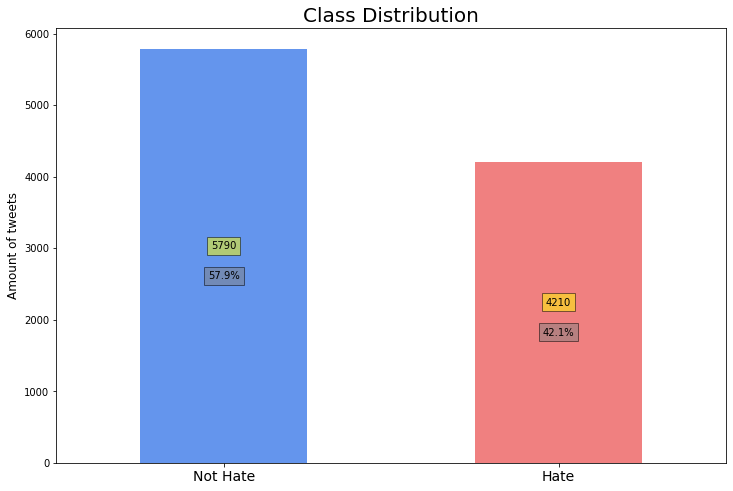

In [6]:
plot_data(data, "label")

In [7]:
NoHate = data[(data['label'] == 'Not Hate')]
Hate = data[(data['label'] == 'Hate')]

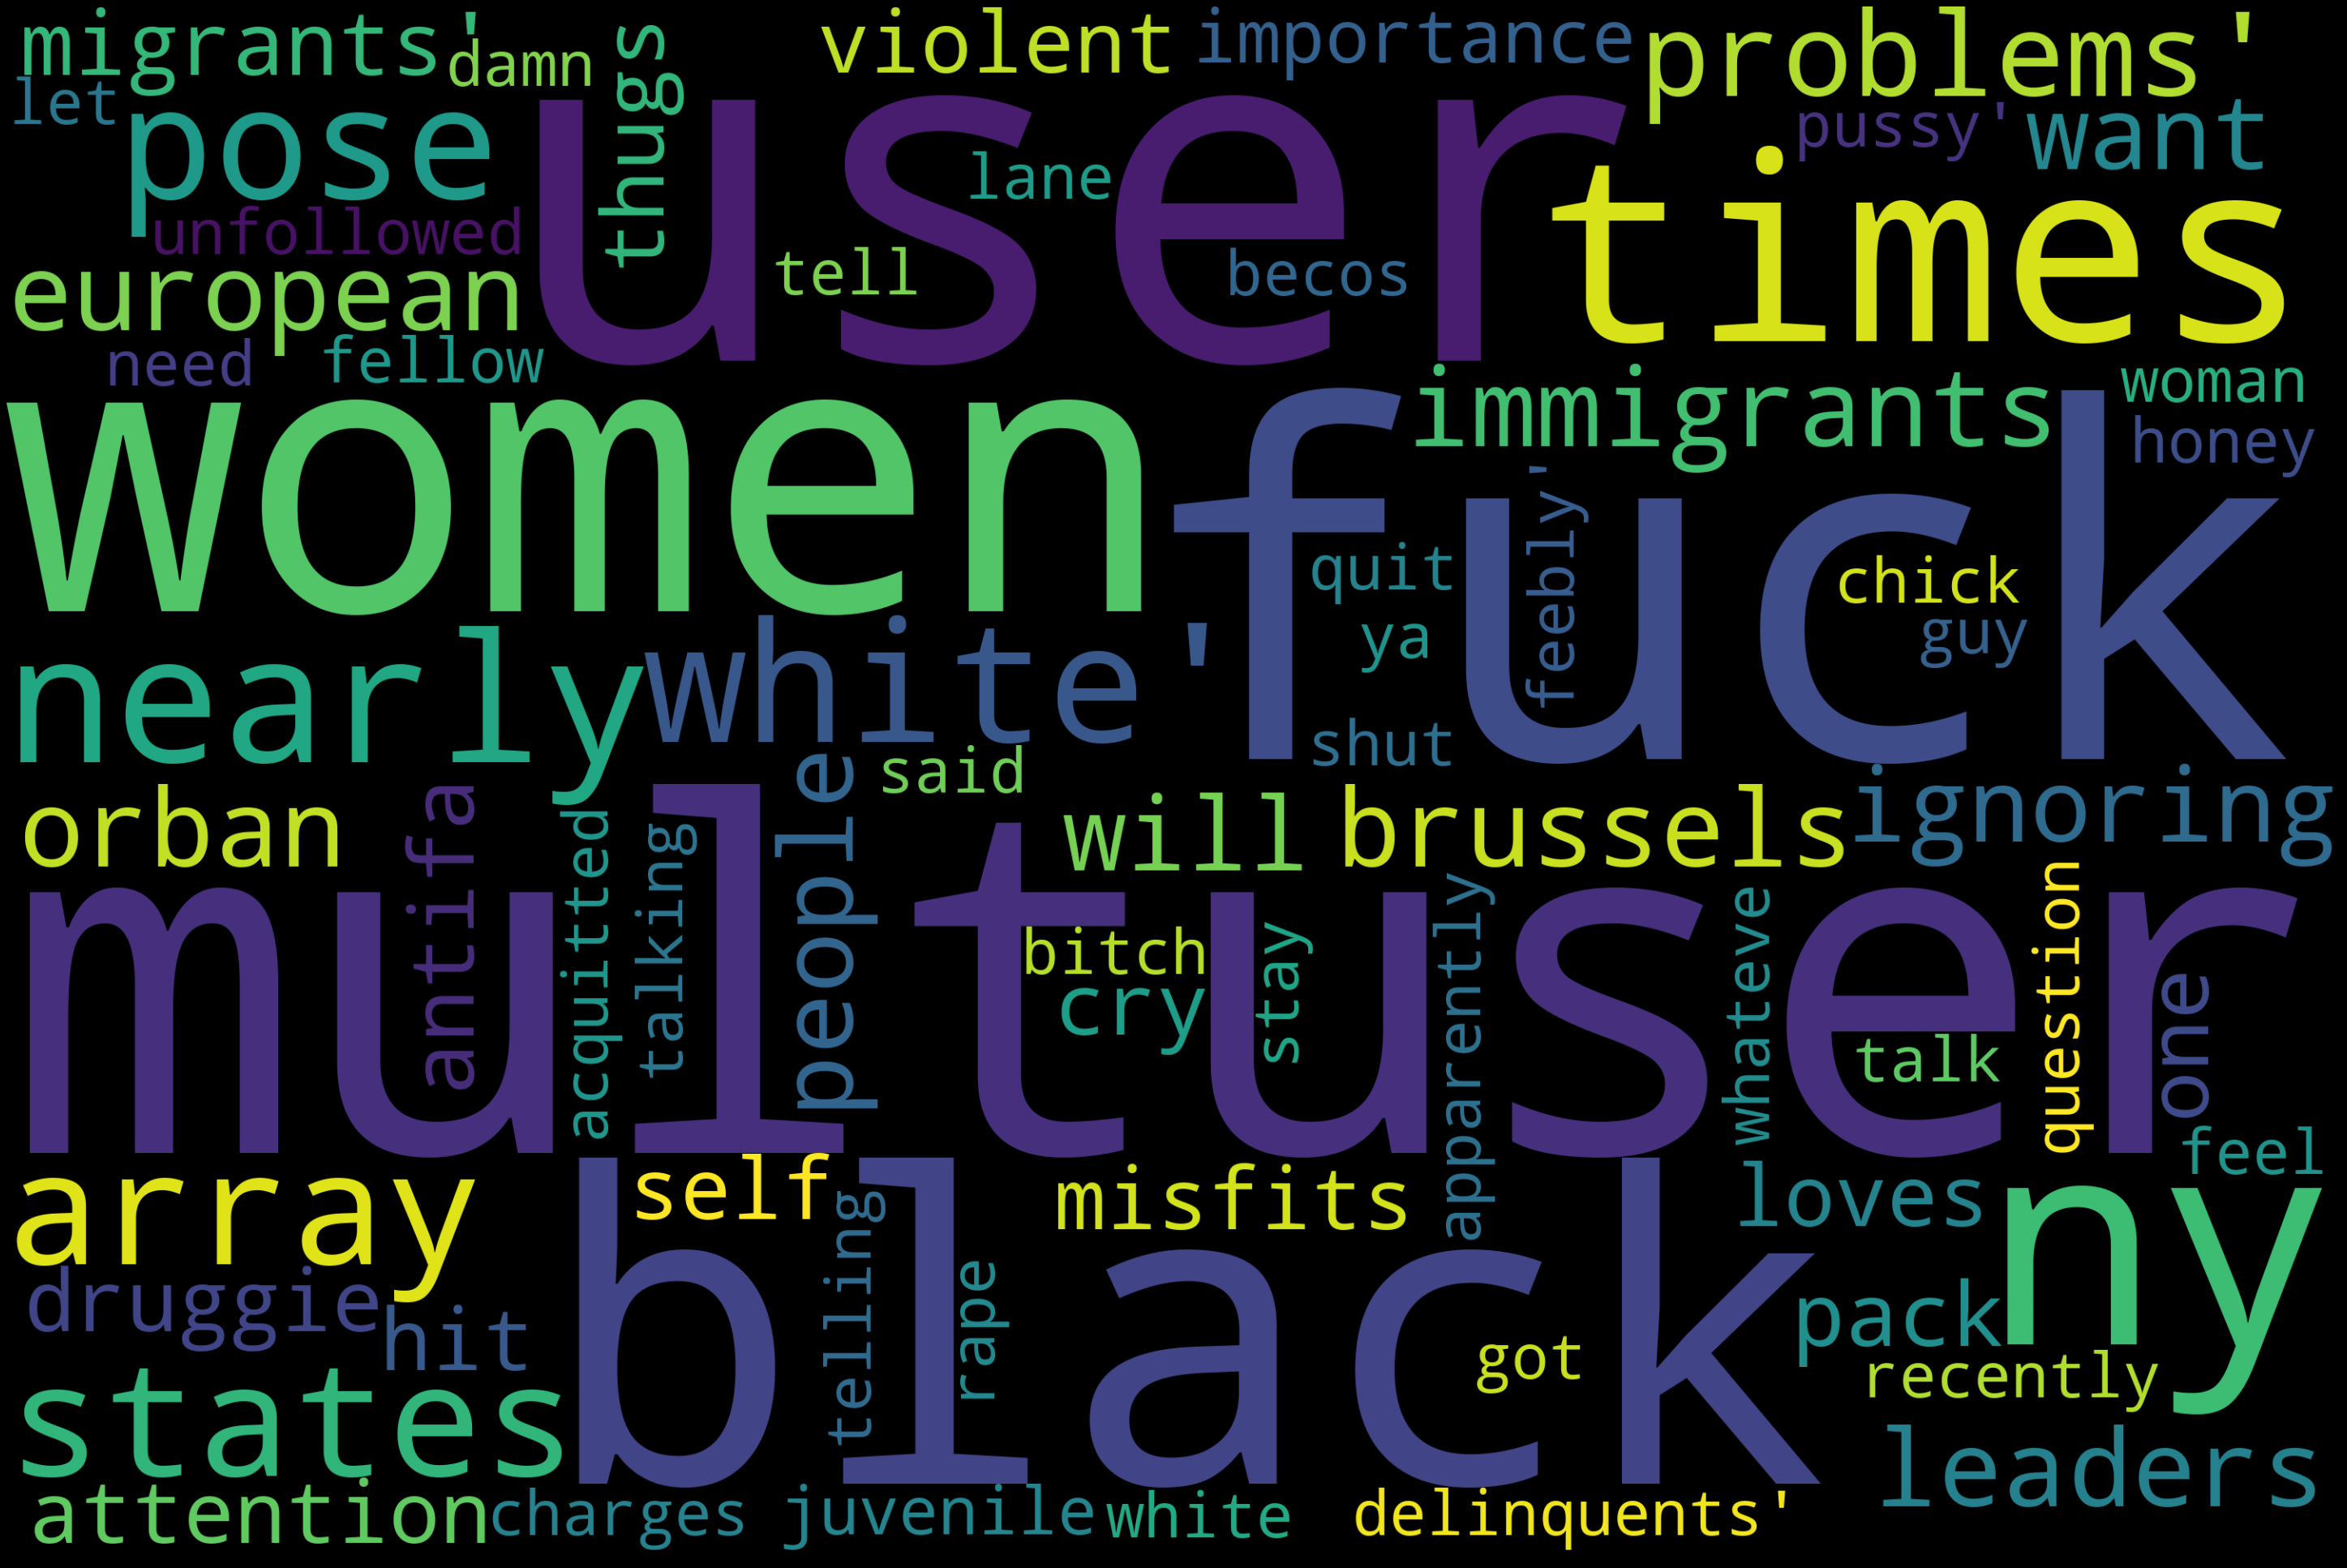

In [8]:
plot_word_cloud(NoHate)

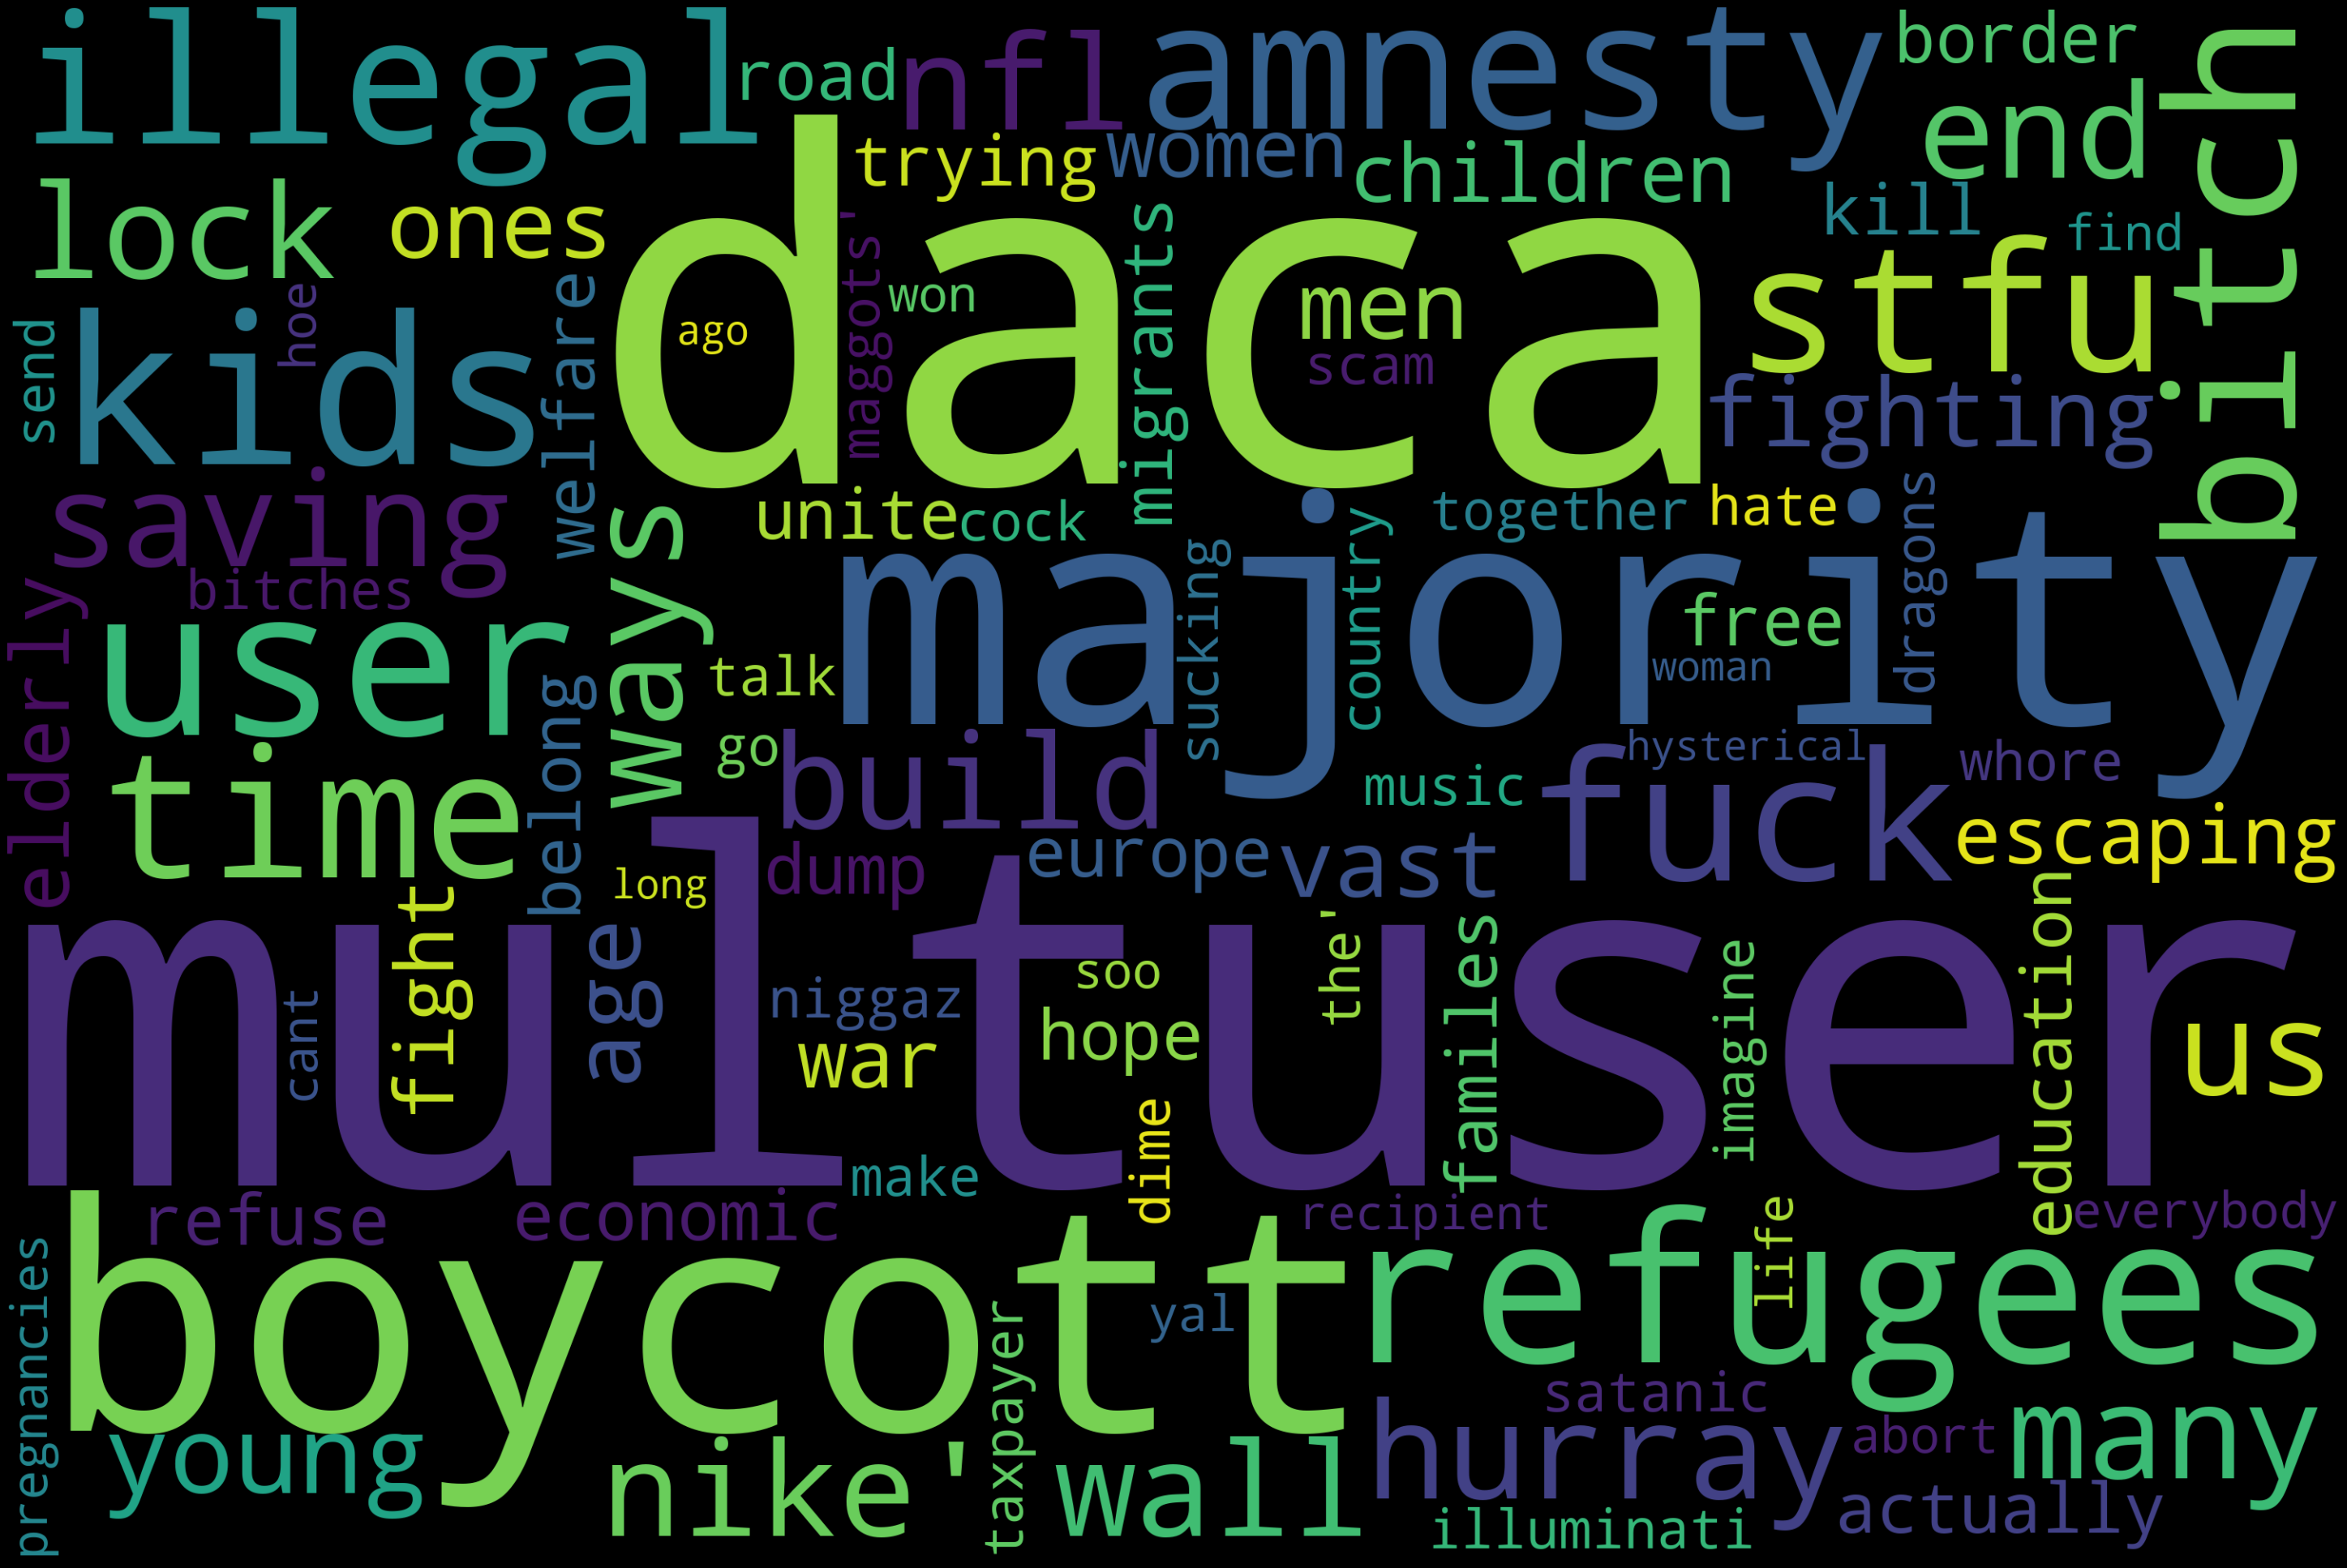

In [9]:
plot_word_cloud(Hate)

## Comparing different methods of text pre-processing 


In [42]:
preprocdat = pd.read_csv('gs://csc3002/hateval2019/preprocess_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
preprocdat.dropna(inplace = True)
#preprocdat = preprocdat.iloc[:11]
preprocdat.drop(["ReplaceEmojiWithWords", "ReplaceEmojiWithTokens", "Hashtag Segmentation","Remove Punctuation", "Lemmatize Text","Remove Stopwords", "HashSeg + PuncRem + ReplaceEmojiWithTokens"], axis = 0, inplace = True)
preprocdat

Accuracy  F1 Score       auc  \
Basic                                      76.370000  0.727456  0.756590   
HashSeg + ReplaceEmojiWithWords            78.331750  0.748646  0.781189   
HashSeg + PuncRem + ReplaceEmojiWithWords  79.050000  0.751763  0.785660   
HashSeg + ReplaceEmojiWithTokens           78.252500  0.746762  0.780197   
HashSeg + ReplaceEmojiWithTokens           0.803000   0.769353  0.800061   
HashSeg + ReplaceEmojiWithWords            80.256696  0.773589  0.803000   
HashSeg + PuncRem + ReplaceEmojiWithWords  80.690000  0.775629  0.805007   

                                           Precision    Recall  \
Basic                                      0.711958   0.711770   
HashSeg + ReplaceEmojiWithWords            0.733675   0.768395   
HashSeg + PuncRem + ReplaceEmojiWithWords  0.750217   0.754880   
HashSeg + ReplaceEmojiWithTokens           0.732840   0.765444   
HashSeg + ReplaceEmojiWithTokens           0.759145   0.781462   
HashSeg + ReplaceEmojiWithWords            0.750535   0.799769   
HashSeg + PuncRem + ReplaceEmojiWithWords  0.760664   0.792899   

                                           False Negatives  False Positives  \
Basic                                      48.53            45.99             
HashSeg + ReplaceEmojiWithWords            39.02            47.71             
HashSeg + PuncRem + ReplaceEmojiWithWords  41.28            42.52             
HashSeg + ReplaceEmojiWithTokens           39.50            47.49             
HashSeg + ReplaceEmojiWithTokens           36.80            42.00             
HashSeg + ReplaceEmojiWithWords            33.72            45.08             
HashSeg + PuncRem + ReplaceEmojiWithWords  34.88            42.36             

                                           True Negatives  True Positives  \
Basic                                      185.60          119.88           
HashSeg + ReplaceEmojiWithWords            183.83          129.44           
HashSeg + PuncRem + ReplaceEmojiWithWords  189.08          127.12           
HashSeg + ReplaceEmojiWithTokens           184.10          128.91           
HashSeg + ReplaceEmojiWithTokens           189.60          131.60           
HashSeg + ReplaceEmojiWithWords            186.52          134.68           
HashSeg + PuncRem + ReplaceEmojiWithWords  189.24          133.52           

                                                       Training Time  \
Basic                                      0 days 00:06:02.896088370   
HashSeg + ReplaceEmojiWithWords            0 days 00:05:25.421199      
HashSeg + PuncRem + ReplaceEmojiWithWords  0 days 00:08:03.884140      
HashSeg + ReplaceEmojiWithTokens           0 days 00:05:59.213520      
HashSeg + ReplaceEmojiWithTokens           0 days 00:08:40.032242      
HashSeg + ReplaceEmojiWithWords            0 days 00:05:43.747153      
HashSeg + PuncRem + ReplaceEmojiWithWords  0 days 00:08:58.996820      

                                                    Pretrained  
Basic                                      Before Pre-Training  
HashSeg + ReplaceEmojiWithWords            Before Pre-Training  
HashSeg + PuncRem + ReplaceEmojiWithWords  Before Pre-Training  
HashSeg + ReplaceEmojiWithTokens           Before Pre-Training  
HashSeg + ReplaceEmojiWithTokens           After Pre-Training   
HashSeg + ReplaceEmojiWithWords            After Pre-Training   
HashSeg + PuncRem + ReplaceEmojiWithWords  After Pre-Training

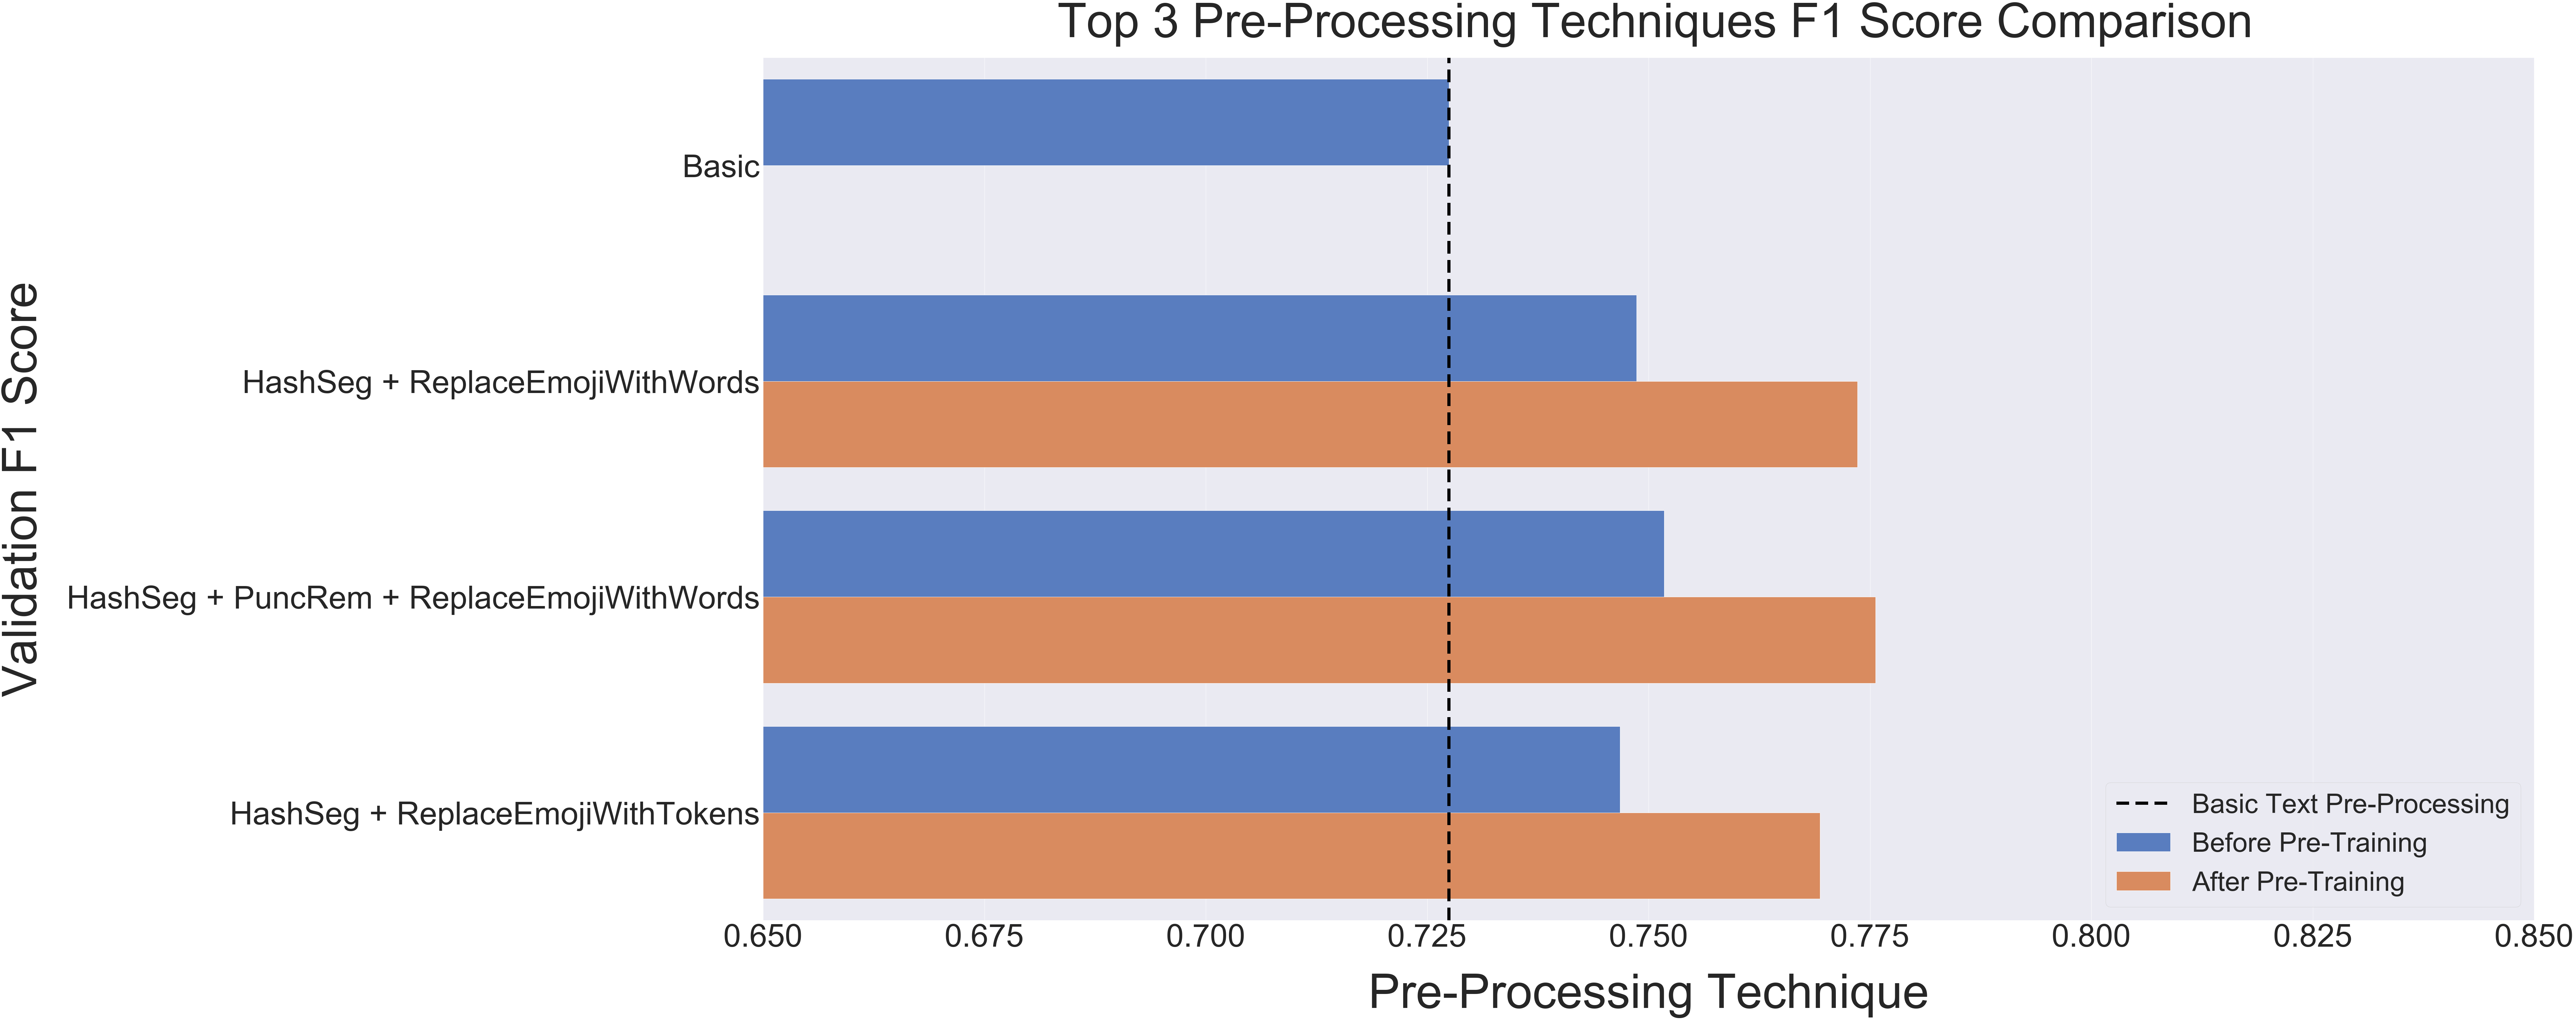

In [43]:
sns.set(style = "darkgrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(100, 50))

#Plot before pre-training
with sns.color_palette("muted", 12):
    sns.barplot(y = preprocdat.index, x ="F1 Score",data = preprocdat, hue = "Pretrained")

    titleSize = 150
    tickSize = 100
    padSize = 65
    plt.title(" Top 3 Pre-Processing Techniques F1 Score Comparison", \
              fontsize = titleSize, pad = padSize )

    plt.ylabel("Validation F1 Score", fontsize = titleSize, labelpad =padSize)
    plt.xlabel("Pre-Processing Technique", fontsize = titleSize, labelpad =padSize)
    plt.xticks(fontsize = tickSize)
    plt.yticks(fontsize = tickSize)
    plt.xlim(0.65, 0.85)

    threshold = preprocdat.loc['Basic']['F1 Score']
    ax.axvline(threshold, 0,1, label='Basic Text Pre-Processing', color = "black",\
               linestyle = "--", lw = 10.0, dashes = [4,2])

    ax.legend(prop = {'size': 85} )

    #Save figure
    fig = ax.get_figure()
    fig.savefig('output.png', bbox_inches ='tight') 
    plt.show()

## Comparing different steps of further pre-training
    
The first dataset was further pre-trained with a learning rate of 5e-5. The other was further-pretrained with a learning rate of 2e-5

In [3]:
pretraindat = pd.read_csv('gs://csc3002/hateval2019/pretraining_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
pretraindat.index = (pretraindat.index/1000).astype(int)
pretraindat

F1 Score       auc  Accuracy  False Negatives  False Positives  \
120  0.763358  0.798466  0.803061  38.20            39.00             
100  0.764554  0.795330  0.798469  37.08            41.92             
80   0.767475  0.796891  0.798265  35.00            44.08             
60   0.758429  0.783174  0.788163  41.16            41.88             
40   0.748400  0.775228  0.781429  43.80            41.88             
0    0.725141  0.731132  0.748469  62.44            36.16             

     Precision    Recall              Training Time  True Negatives  \
120  0.766623   0.769235  0.004281233                187.40           
100  0.755519   0.775787  0 days 00:05:30.002256     184.60           
80   0.749522   0.788458  0 days 00:05:30.042791     182.44           
60   0.720442   0.751278  0 days 00:05:41.106568     184.64           
40   0.715475   0.735362  0 days 00:06:17.175884     184.64           
0    0.593161   0.622031  0 days 00:05:28.497110440  190.36           

     True Positives  
120  127.40          
100  128.40          
80   130.48          
60   124.32          
40   121.68          
0    103.04

In [4]:
pretraindat1 = pd.read_csv('gs://csc3002/hateval2019/pretraining_eval_df1.csv', sep=',',  index_col = 0, encoding = 'utf-8')
pretraindat1.index = [120, 100, 80,60,40, 0]
pretraindat1.index = pretraindat1.index.astype(int)
pretraindat1

F1 Score       auc  Accuracy  False Negatives  False Positives  \
120  0.765190  0.795195  0.797245  36.0000          43.4800           
100  0.768301  0.798551  0.800200  35.6800          44.2400           
80   0.768081  0.799007  0.801600  36.6000          42.7600           
60   0.767117  0.797896  0.800300  36.6200          43.2600           
40   0.757157  0.789982  0.793500  39.1125          43.4875           
0    0.725141  0.731132  0.748469  62.4400          36.1600           

     Precision    Recall              Training Time  True Negatives  \
120  0.750553   0.782374  0 days 00:05:34.251366640  183.04           
100  0.751556   0.788115  0 days 00:06:09.480712     187.36           
80   0.756257   0.782642  0 days 00:05:50.962482     188.84           
60   0.754029   0.782588  0 days 00:05:39.230519     188.32           
40   0.749598   0.767707  0.003935796                188.15           
0    0.593161   0.622031  0 days 00:05:28.497110440  190.36           

     True Positives  
120  129.48          
100  132.72          
80   131.80          
60   131.80          
40   129.25          
0    103.04

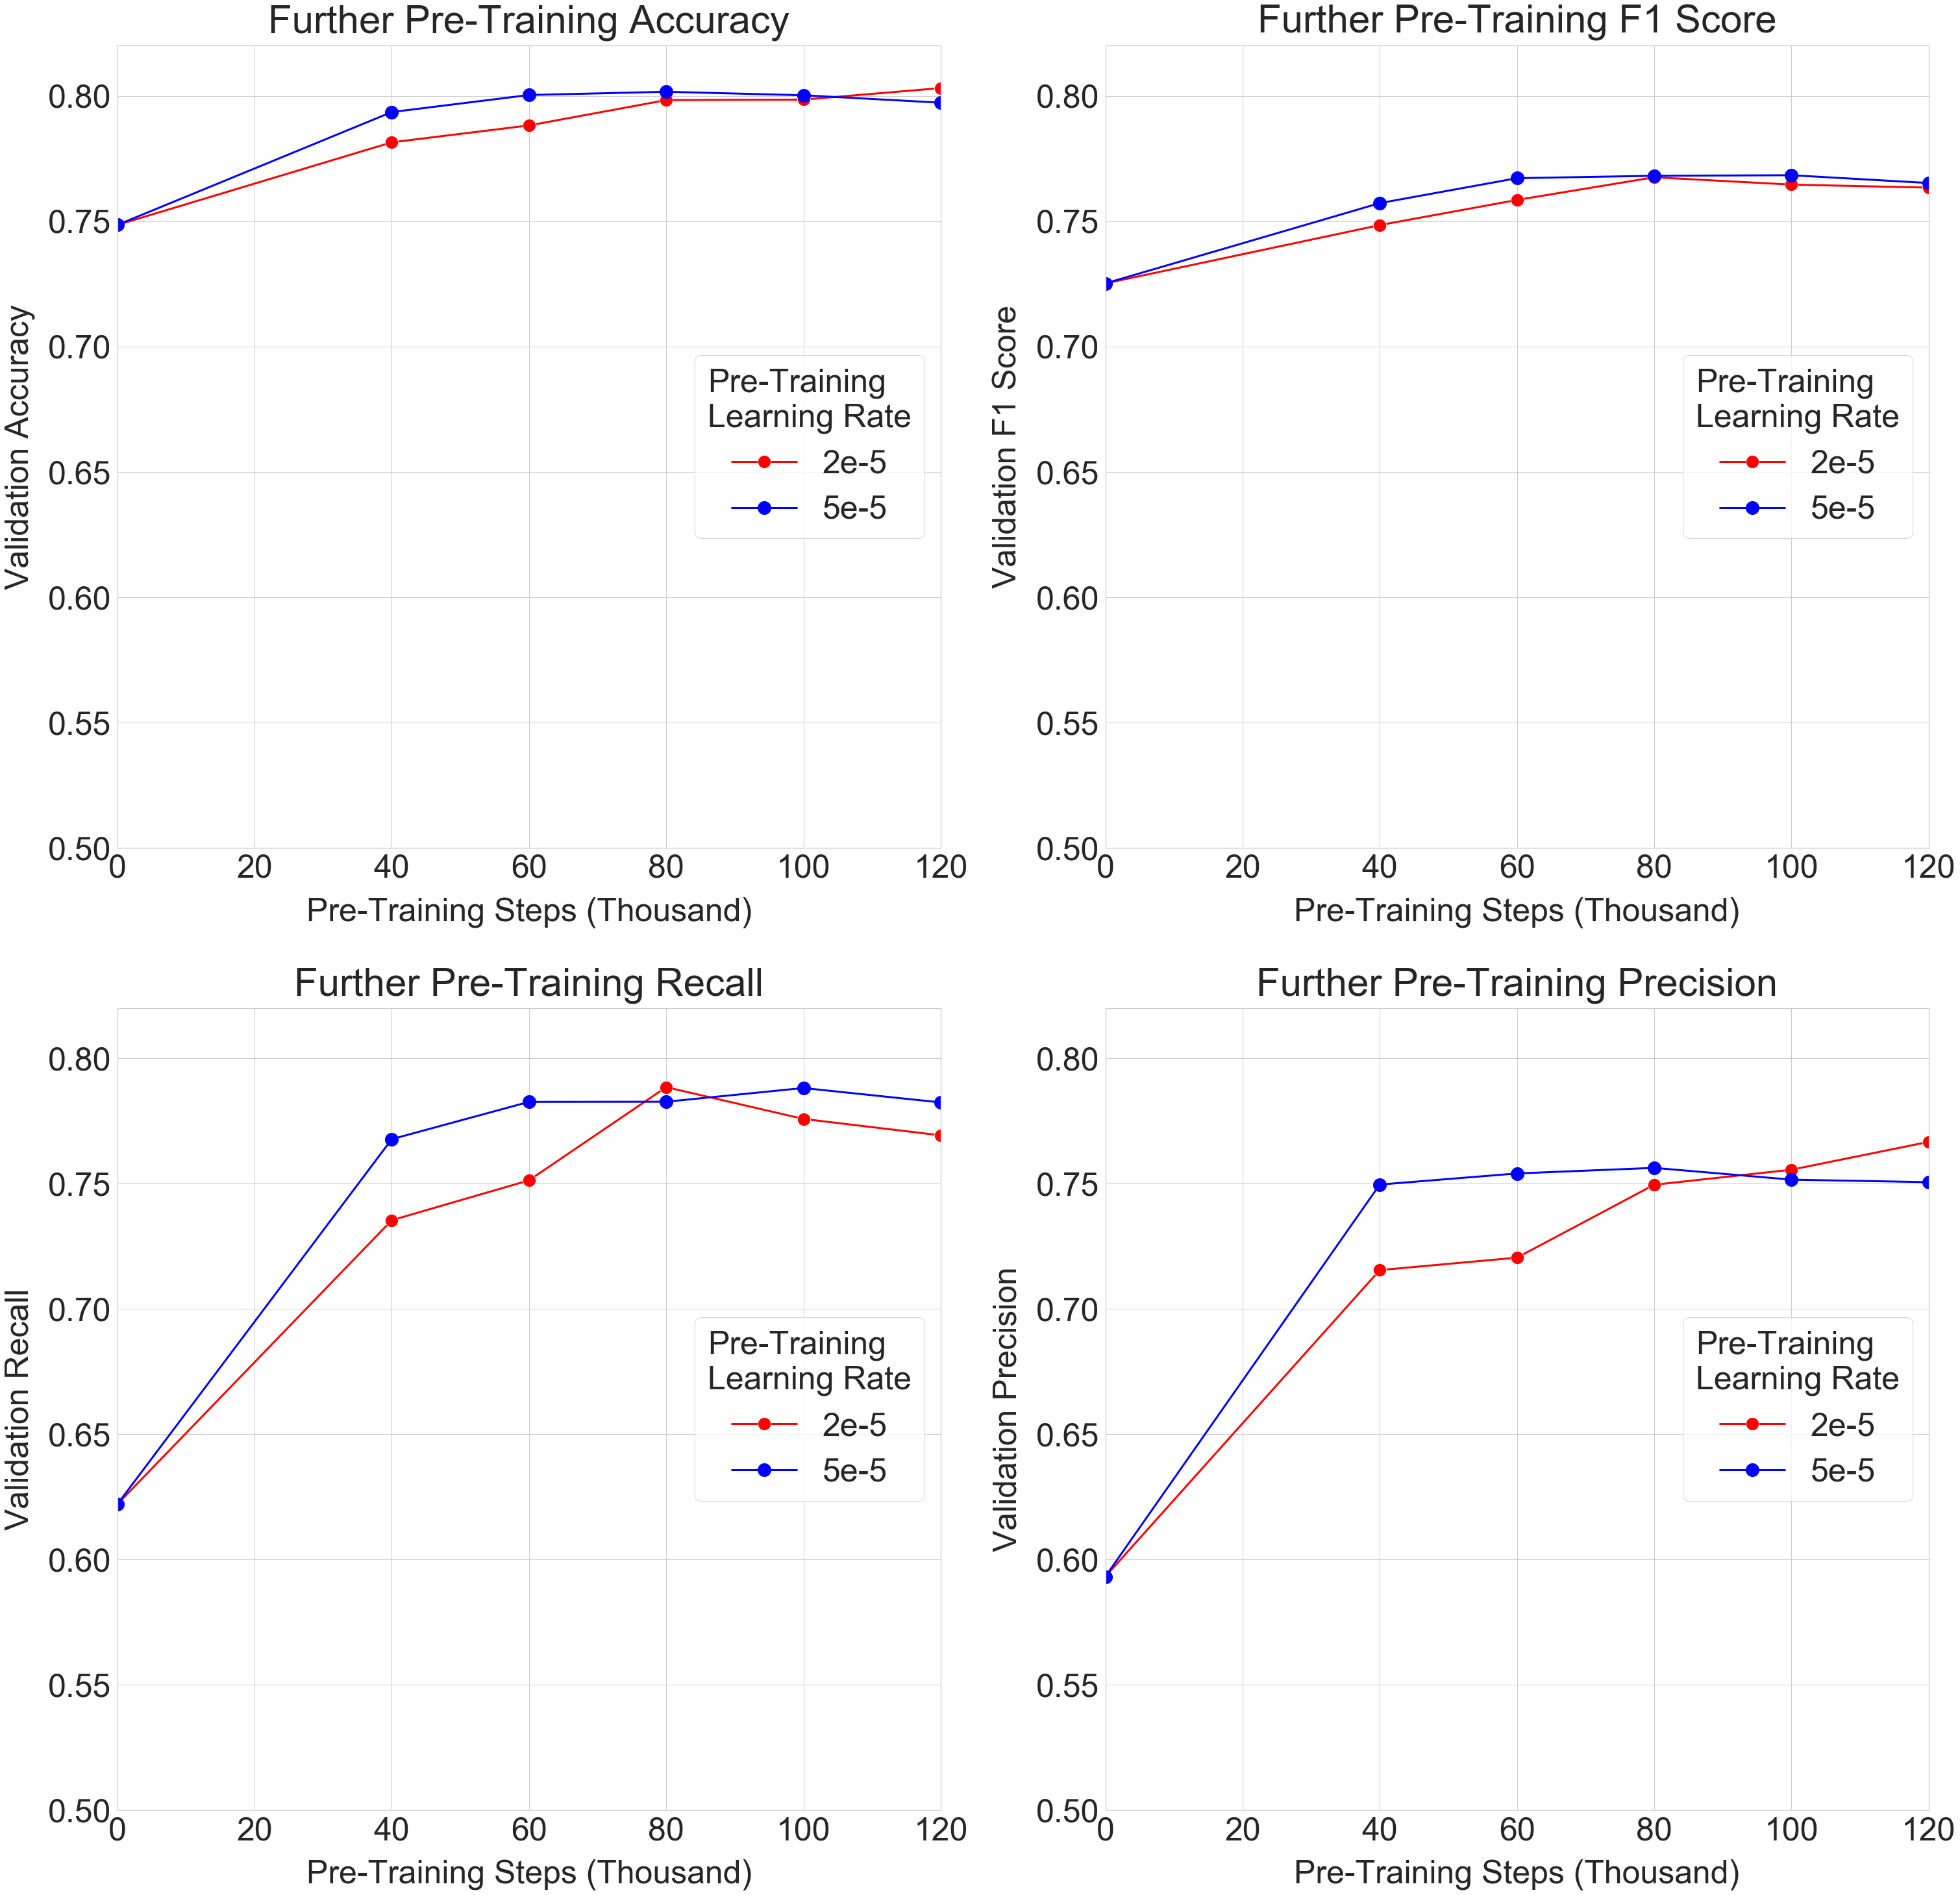

In [5]:
sns.set(style = 'whitegrid', \
        rc={'figure.figsize':(50,50), "lines.linewidth": 3, \
            'lines.markersize': 20, 'xtick.labelsize': 50, 'ytick.labelsize': 50,\
           'axes.titlesize': 60, 'axes.labelsize': 50, 'axes.labelpad': 20,\
           'legend.title_fontsize': 50, 'legend.loc': 'center right', \
            'legend.fontsize': 'large'})

padsize = 20
metrics = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
for i in range(1,len(metrics) + 1):
    plt.subplot(2,2,i)
    ax = sns.lineplot(x = pretraindat.index, y = metrics[i-1],\
                      data = pretraindat, marker = 'o', color = 'red')
    plt.title("Further Pre-Training " + metrics[i-1] , pad =padsize)
    plt.ylabel("Validation " + metrics[i-1], labelpad =padsize)
    plt.xlabel("Pre-Training Steps (Thousand)",labelpad =padsize)
    ax.set_ylim(0.5, 0.82)
    ax.set_xlim(0, 130)
    pretraindat1[metrics[i-1]].plot(ax = ax, marker = 'o', color = 'blue')
    ax.legend(labels = ['2e-5', '5e-5'], title = 'Pre-Training\nLearning Rate', \
              prop = {'size': 50})
fig = ax.get_figure()
fig.savefig('output.png', bbox_inches ='tight') 
plt.show()

In [11]:
noRemTerms = pd.read_csv('gs://csc3002/hateval2019/noRemTerms_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
noRemTerms.index = [120, 100, 80,60,40,0]
noRemTerms.index = noRemTerms.index.astype(int)
#noRemTerms.at[80, 'Accuracy'] = 0.809
noRemTerms

F1 Score       auc  Accuracy  False Negatives  False Positives  \
120  0.771988  0.803006  0.806225  36.62            40.89             
100  0.775150  0.805582  0.808800  36.16            40.32             
80   0.775629  0.805007  0.809000  34.88            42.36             
60   0.775507  0.805577  0.808550  35.92            40.66             
40   0.769353  0.800061  0.803000  36.80            42.00             
0    0.725141  0.731132  0.748469  62.44            36.16             

     Precision    Recall              Training Time  True Negatives  \
120  0.764466   0.782570  0 days 00:06:35.564023     190.69           
100  0.767534   0.785265  0 days 00:05:37.702464     191.28           
80   0.760664   0.792899  0.003896215                189.24           
60   0.766980   0.786737  0 days 00:06:38.178697     190.90           
40   0.759145   0.781462  0 days 00:06:10.201610     189.60           
0    0.593161   0.622031  0 days 00:05:28.497110440  190.36           

     True Positives  
120  131.80          
100  132.24          
80   133.52          
60   132.52          
40   131.60          
0    103.04

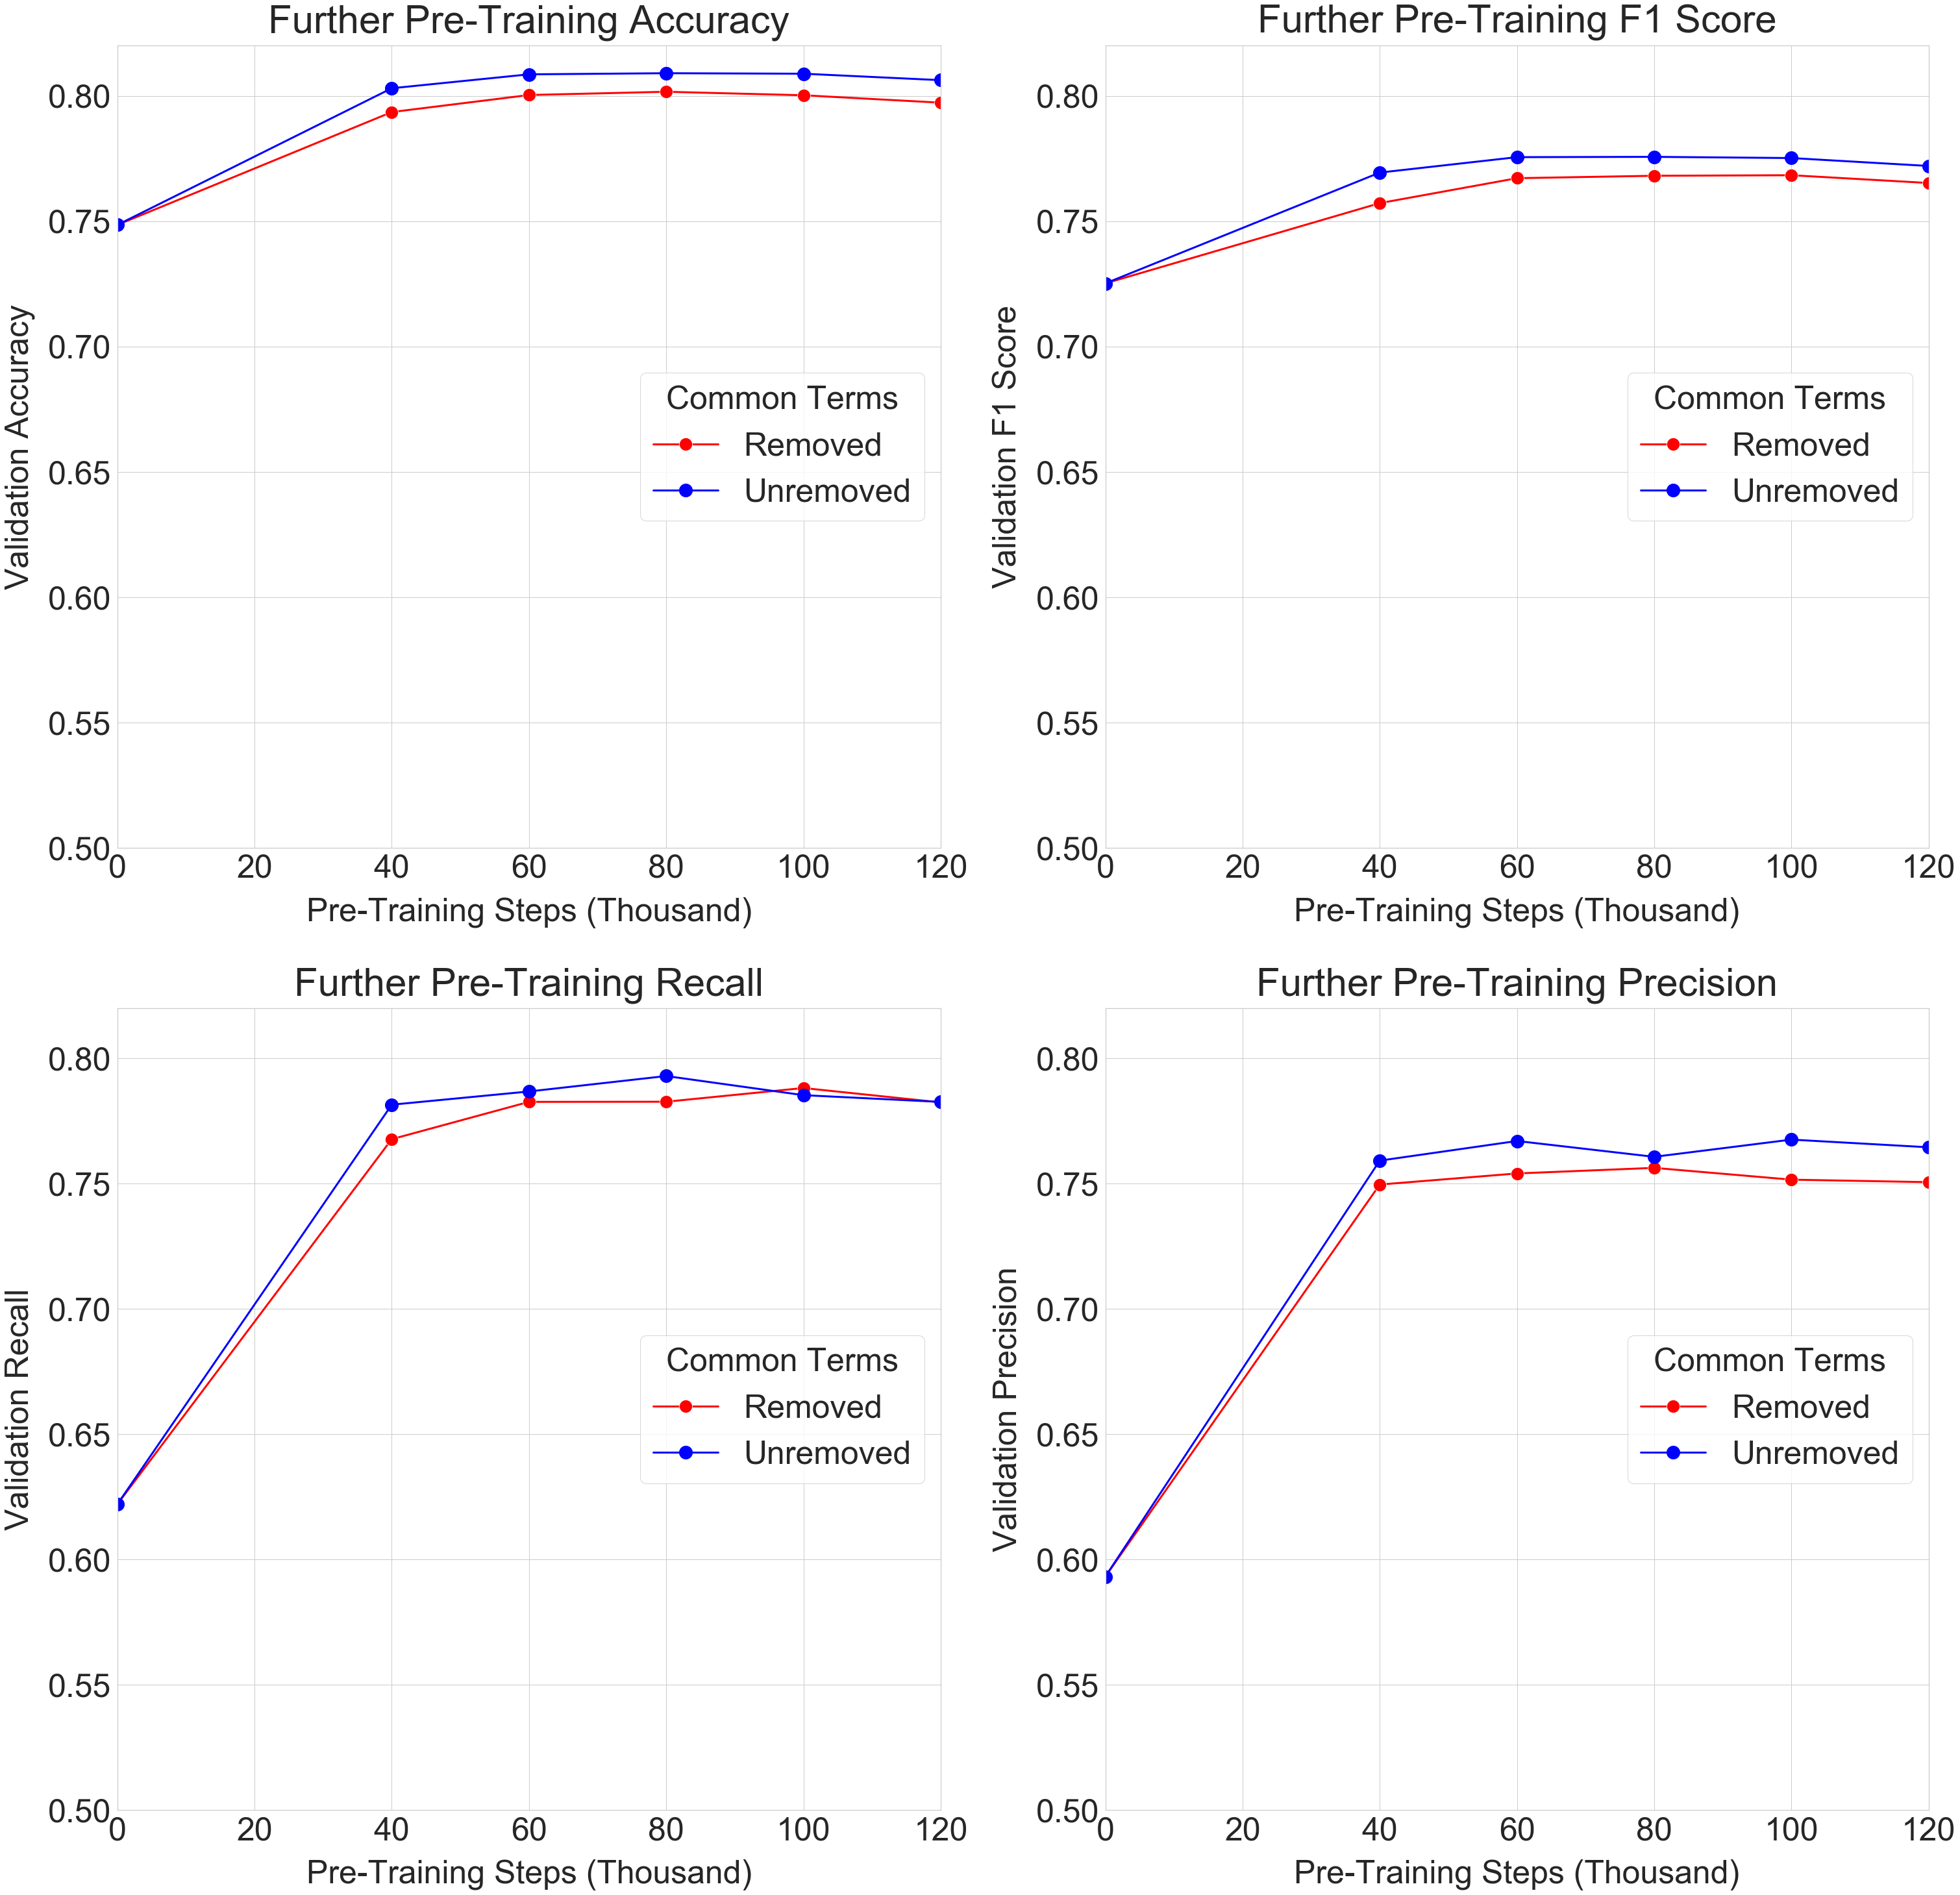

In [12]:
for i in range(1,len(metrics) + 1):
    plt.subplot(2,2,i)
    ax = sns.lineplot(x = pretraindat1.index, y = metrics[i-1],\
                      data = pretraindat1, marker = 'o', color = 'red')
    plt.title("Further Pre-Training " + metrics[i-1] , pad =padsize)
    plt.ylabel("Validation " + metrics[i-1], labelpad =padsize)
    plt.xlabel("Pre-Training Steps (Thousand)",labelpad =padsize)
    plt.ylim(0.5, 0.82)
    plt.xlim(0, 130)
    noRemTerms[metrics[i-1]].plot(ax = ax, marker = 'o', color = 'blue')
    ax.legend(labels = ['Removed', 'Unremoved'], \
              title = 'Common Terms' ,prop = {'size': 50})
    
fig = ax.get_figure()
fig.savefig('output.png', bbox_inches ='tight')

plt.show()

In [13]:
emoj = pd.read_csv('gs://csc3002/hateval2019/emojiReplacev2_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
emoj.index = [120, 100, 80, 60,40, 0]
emoj.index = emoj.index.astype(int)
emoj

F1 Score       auc  Accuracy  False Negatives  False Positives  \
120  0.771481  0.801423  0.803300  35.44            43.24             
100  0.768644  0.798993  0.801200  36.20            43.32             
80   0.773589  0.802567  0.803000  33.72            45.08             
60   0.767041  0.797590  0.799800  36.44            43.64             
40   0.768217  0.798880  0.801125  36.25            43.30             
0    0.725141  0.731132  0.748469  62.44            36.16             

     Precision    Recall              Training Time  True Negatives  \
120  0.755624   0.789551  0 days 00:05:32.180641     188.36           
100  0.754275   0.785031  0 days 00:06:32.344663880  188.28           
80   0.750535   0.799769  0 days 00:05:43.747153     186.52           
60   0.753509   0.783597  0 days 00:05:42.780247     187.96           
40   0.754268   0.784694  0 days 00:05:35.112138     188.33           
0    0.593161   0.622031  0 days 00:05:28.497110440  190.36           

     True Positives  
120  132.96          
100  132.20          
80   134.68          
60   131.96          
40   132.12          
0    103.04

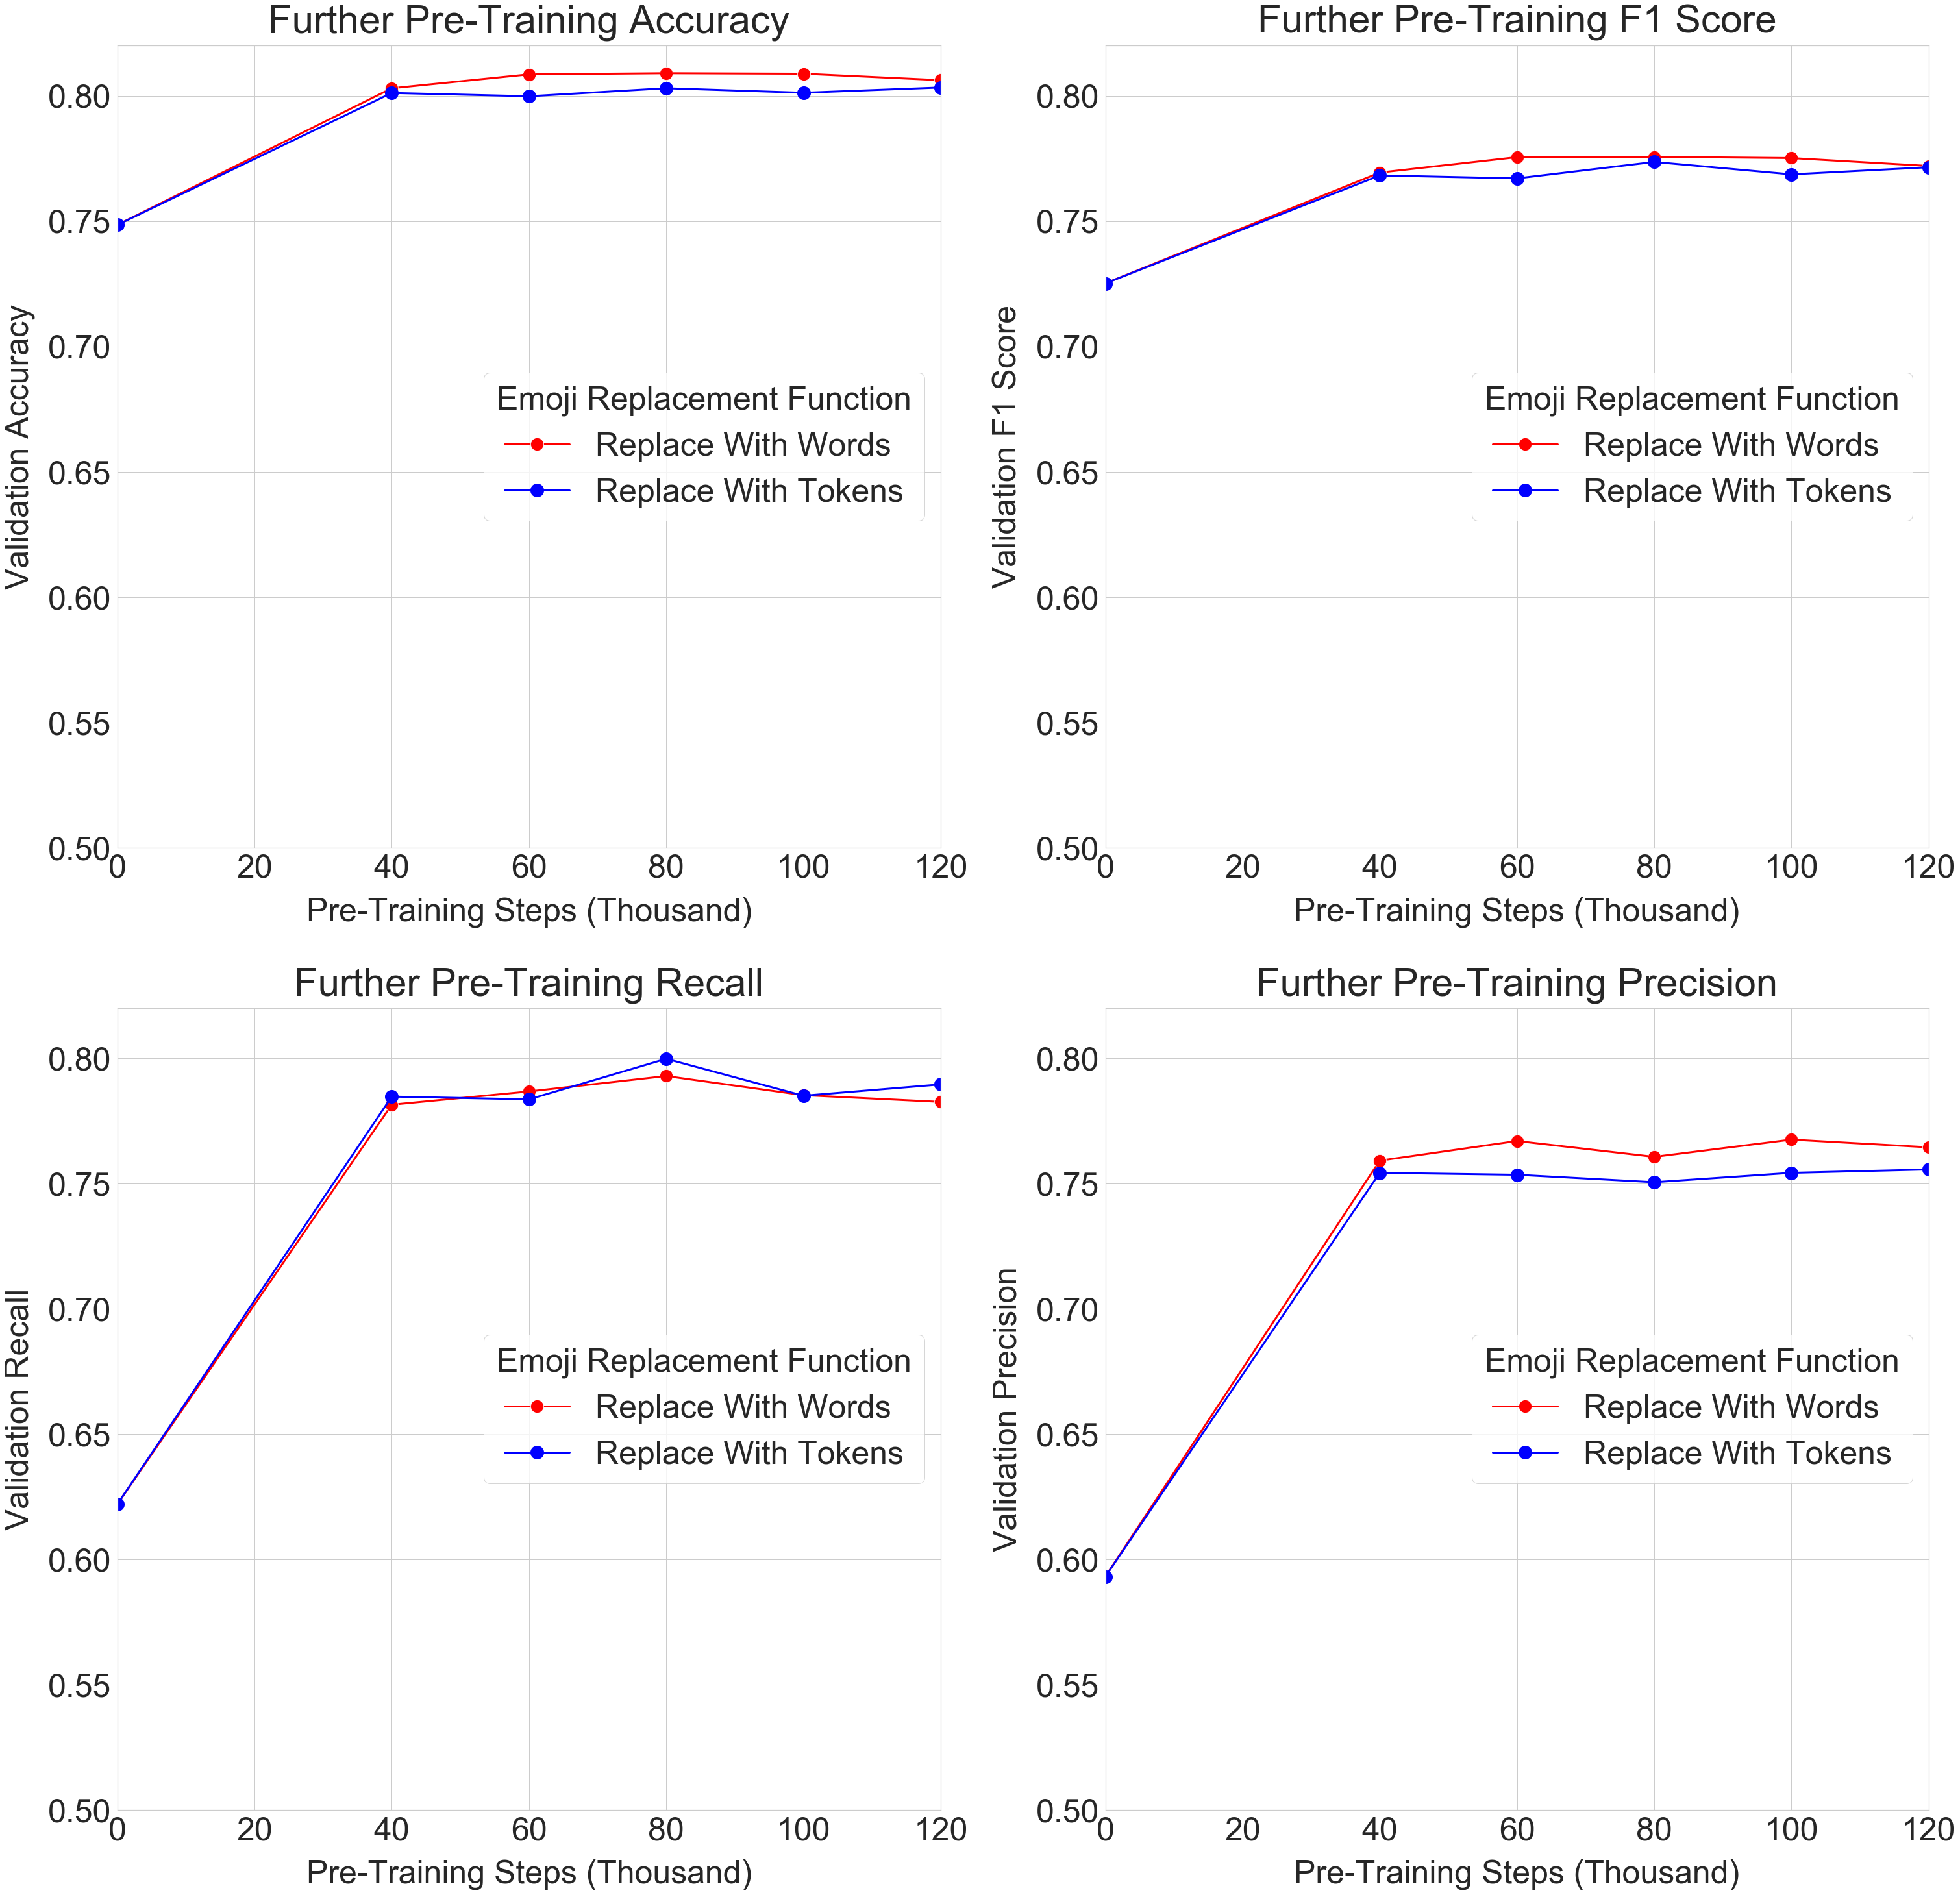

In [14]:
for i in range(1,len(metrics) + 1):
    plt.subplot(2,2,i)
    ax = sns.lineplot(x = noRemTerms.index, y = metrics[i-1],\
                      data = noRemTerms, marker = 'o', color = 'red')
    plt.title("Further Pre-Training " + metrics[i-1] , pad =padsize)
    plt.ylabel("Validation " + metrics[i-1], labelpad =padsize)
    plt.xlabel("Pre-Training Steps (Thousand)",labelpad =padsize)
    plt.ylim(0.5, 0.82)
    plt.xlim(0, 130)
    emoj[metrics[i-1]].plot(ax = ax, marker = 'o', color = 'blue')
    ax.legend(labels = ['Replace With Words', 'Replace With Tokens'], \
              title = 'Emoji Replacement Function' ,prop = {'size': 50})
    
fig = ax.get_figure()
fig.savefig('output.png', bbox_inches ='tight')
plt.show()

## Different Loss Functions

Trying different loss functions and seeing whether they make a large overall impact on performance.

In [10]:
loss = pd.read_csv('gs://csc3002/hateval2019/loss_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
loss.dropna(inplace = True)
loss.head()

Accuracy       auc  F1 Score  False Negatives  \
Default - Cross-Entropy  0.8026    0.800349  0.769899  36.04             
Focal Loss               0.8064    0.803365  0.773095  36.36             
Weighted Loss            80.6200   0.800986  0.769289  39.08             

                         False Positives  Precision    Recall  \
Default - Cross-Entropy  42.92            0.756813   0.786003   
Focal Loss               41.08            0.763578   0.784096   
Weighted Loss            38.44            0.772304   0.767943   

                                     Training Time  True Negatives  \
Default - Cross-Entropy  0 days 00:06:02.506825560  188.68           
Focal Loss               0 days 00:08:59.133248     190.52           
Weighted Loss            0 days 00:08:45.822352     193.16           

                         True Positives  
Default - Cross-Entropy  132.36          
Focal Loss               132.04          
Weighted Loss            129.32

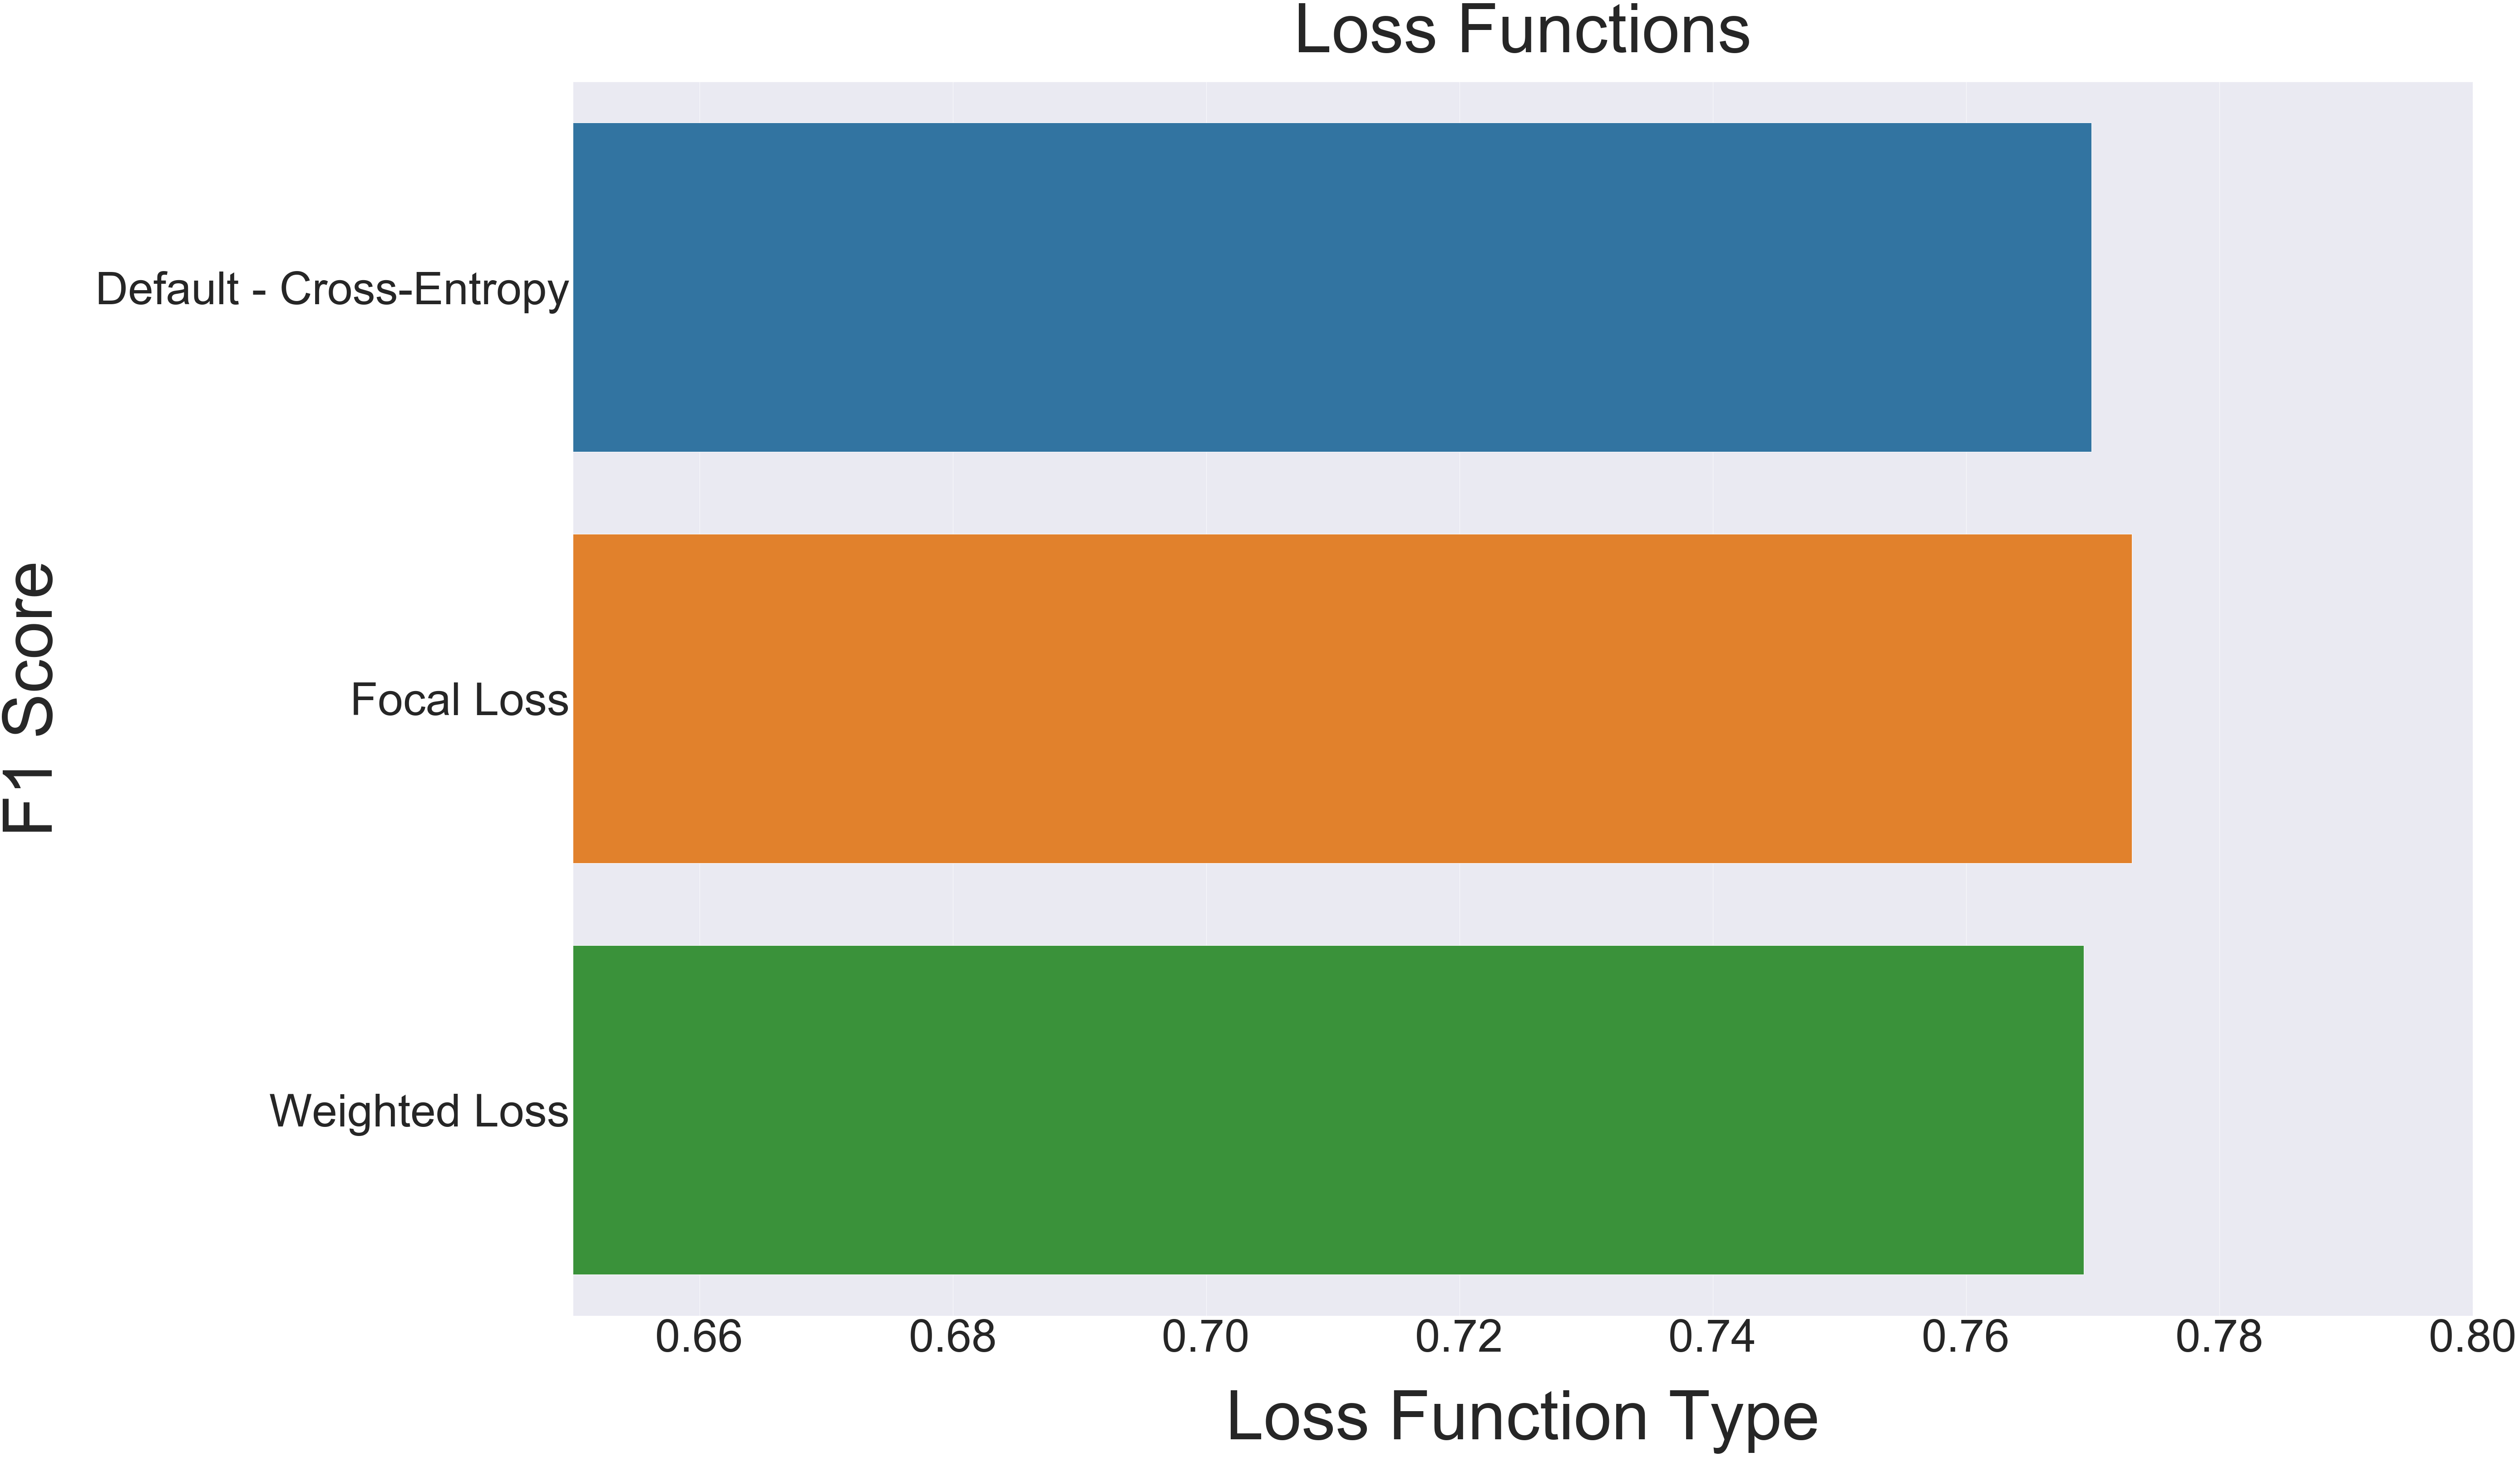

In [12]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(75, 50))
ax = sns.barplot(y=loss.index, x = 'F1 Score', data=loss)
titleSize = 150
tickSize = 100
padSize = 65
plt.title("Loss Functions", fontsize = titleSize, pad = padSize )

plt.ylabel("F1 Score", fontsize = titleSize, labelpad =padSize)
plt.xlabel("Loss Function Type", fontsize = titleSize, labelpad =padSize)
plt.xticks(fontsize = tickSize)
plt.yticks(fontsize = tickSize)
plt.xlim(0.65, 0.80)
plt.show()

## Different Models

In [3]:
model = pd.read_csv('gs://csc3002/hateval2019/models_eval_df.csv', sep=',',  index_col = 0, encoding = 'utf-8')
model

Accuracy  F1 Score       auc  Precision    Recall  \
BERT           80.690000  0.775629  0.805007  0.760664   0.792899   
BERT           80.490000  0.769359  0.800747  0.765995   0.774366   
BERT           80.300000  0.768353  0.799338  0.762605   0.776020   
BERT + BiLTSM  79.720000  0.764397  0.795246  0.748281   0.782888   
BERT + BiLTSM  79.670000  0.763601  0.794610  0.748009   0.781257   
BERT           79.220001  0.754761  0.787863  0.750892   0.760351   
BERT + BiLTSM  79.980001  0.766599  0.797239  0.753896   0.780990   
BERT + BiLTSM  80.050000  0.765123  0.796554  0.761155   0.771512   
BERT           80.630000  0.773532  0.803635  0.762659   0.786706   

               False Negatives  False Positives  True Negatives  \
BERT           34.88            42.36            189.24           
BERT           38.00            40.04            191.56           
BERT           37.72            41.08            190.52           
BERT + BiLTSM  36.56            44.56            187.04           
BERT + BiLTSM  36.84            44.48            187.12           
BERT           40.36            42.76            188.84           
BERT + BiLTSM  36.88            43.20            188.40           
BERT + BiLTSM  38.48            41.32            190.28           
BERT           35.92            41.56            190.04           

               True Positives  Dropout  Added Layers  
BERT           133.52          0.1      0             
BERT           130.40          0.2      1             
BERT           130.68          0.2      2             
BERT + BiLTSM  131.84          0.2      1             
BERT + BiLTSM  131.56          0.2      2             
BERT           128.04          0.3      2             
BERT + BiLTSM  131.52          0.3      2             
BERT + BiLTSM  129.92          0.3      1             
BERT           132.48          0.3      2

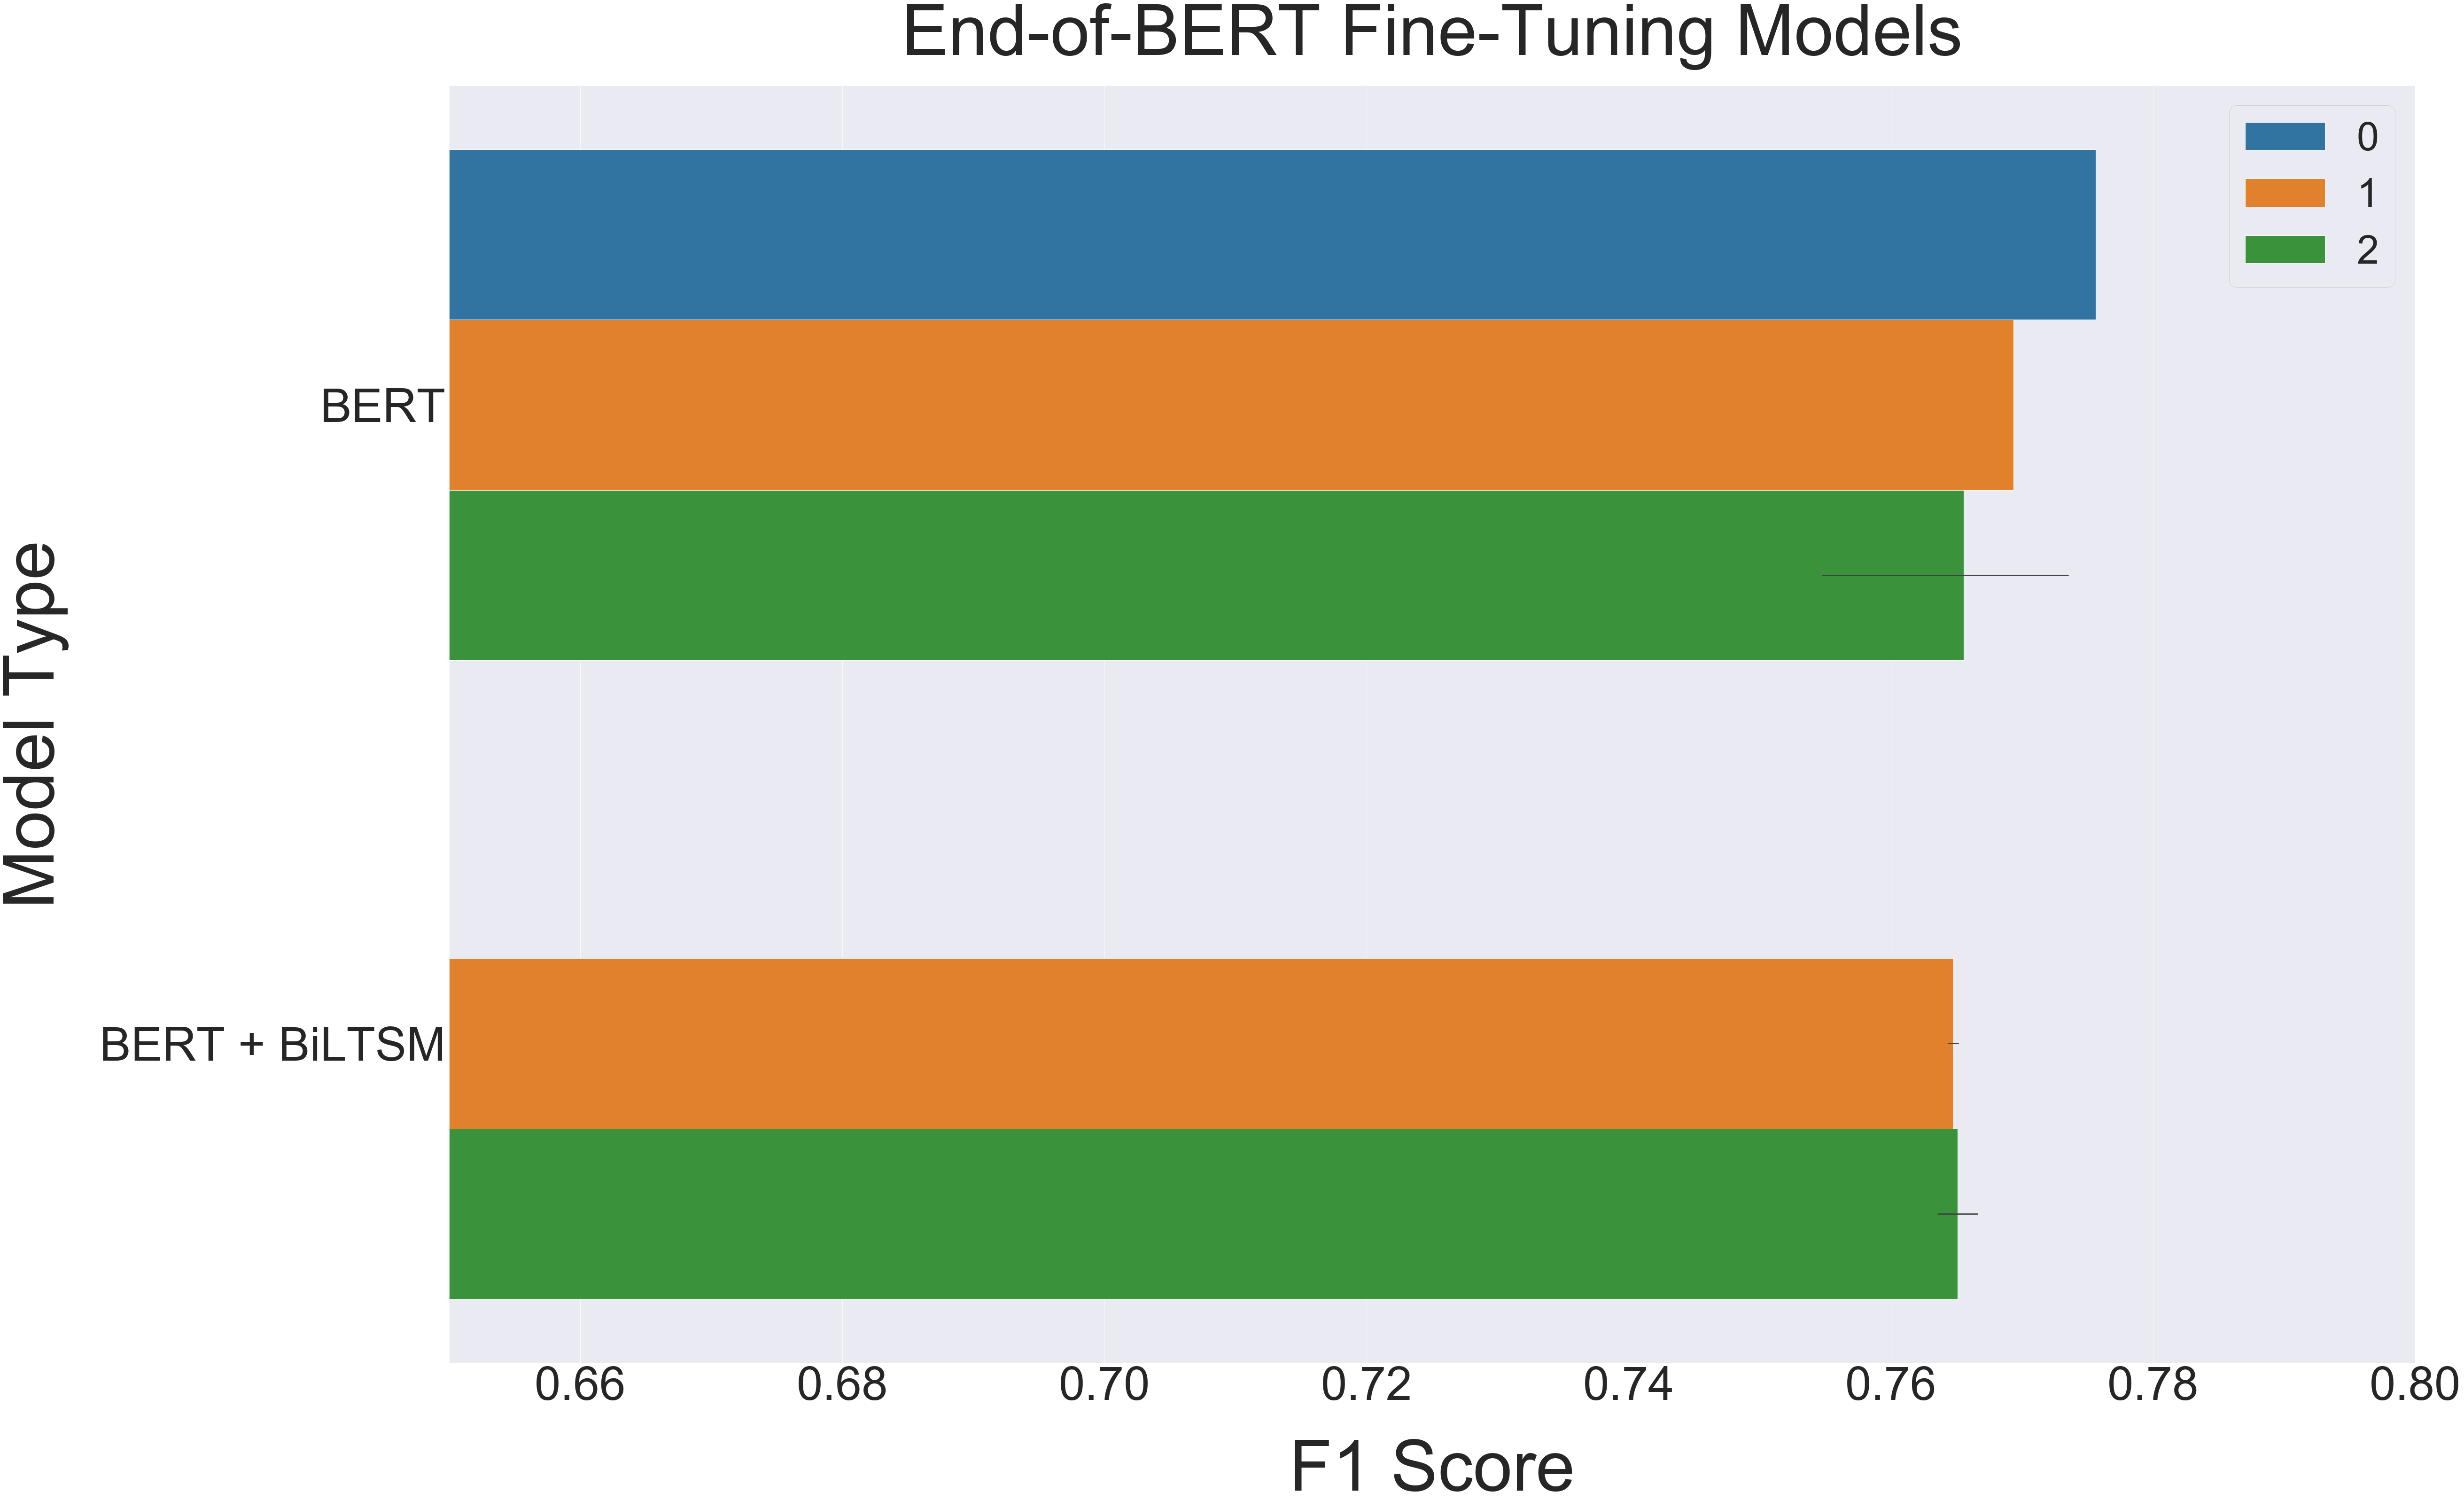

In [4]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(75, 50))
ax = sns.barplot( x = 'F1 Score', y=model.index, data=model, hue = "Added Layers")
titleSize = 150
tickSize = 100
padSize = 65
plt.title("End-of-BERT Fine-Tuning Models", fontsize = titleSize, pad = padSize )

plt.xlabel("F1 Score", fontsize = titleSize, labelpad =padSize)
plt.ylabel("Model Type", fontsize = titleSize, labelpad =padSize)
plt.xticks(fontsize = tickSize)
plt.yticks(fontsize = tickSize)
plt.xlim(0.65, 0.80)

ax.legend(prop = {'size': 85})

plt.show()

## Comparing Misclassifiction Sequence Lengths

Often, LTSMs struggle with long sequence lengths. Let's see if this is the case with this dataset.

Also let's see if the best system for classification, have misclassifications that differ much from the average sequence length of the test set.

All datasets have went through identical pre-processing so the textual content will be the same for each tweet. There will be more tweets in the test set than the misclassification error sets but we will assume equal variance

In [79]:
#Load preprocess functions if you haven't already
%cd Text_Preprocessing
import preprocessing as pre
%cd ..

C:\Users\fionn\Documents\CSC3002_Project\CSC3002_Detecting_Hate_Speech_On_Social_Media\csc3002_detecting_hate_speech\Text_Preprocessing
C:\Users\fionn\Documents\CSC3002_Project\CSC3002_Detecting_Hate_Speech_On_Social_Media\csc3002_detecting_hate_speech


In [80]:
fp = pd.read_csv('gs://csc3002/hateval2019/falsepositives.csv', sep=',')
fp['set'] = 'False Positives'
fp["string_len"] = fp.tweet.str.len()

fn = pd.read_csv('gs://csc3002/hateval2019/falsenegatives.csv', sep=',')
fn['set'] = 'False Negatives'
fn["string_len"] = fn.tweet.str.len()

emoji1 = pd.concat([fn, fp], axis = 0)
emoji1["set"] = "Misclassifications Best Model"
emoji1.drop(['id'],axis = 1, inplace = True)
emoji1["string_len"] = emoji1.tweet.str.len()

"""
fp=[];fn=[]
fp = pd.read_csv('gs://csc3002/hateval2019/falsepositives1.csv', sep=',')
fn = pd.read_csv('gs://csc3002/hateval2019/falsenegatives1.csv', sep=',')
emoji2 = pd.concat([fn, fp], axis = 0)
emoji2["set"] = "emoji2"
emoji2.drop(['id'], axis = 1, inplace = True)
emoji2["string_len"] = emoji2.tweet.str.len()
"""

fp1 = pd.read_csv('gs://csc3002/hateval2019/ltsm_falsepositives.csv', sep=',')
fn1 = pd.read_csv('gs://csc3002/hateval2019/ltsm_falsenegatives.csv', sep=',')
ltsm =  pd.concat([fn1, fp1], axis = 0)
ltsm['set'] = 'Misclassifications LTSM Model'
ltsm.drop(['id'],axis = 1, inplace = True)
ltsm["string_len"] = ltsm.tweet.str.len()

test =  pd.read_csv('Raw_Data/hateval2019/hateval2019_en_test.csv', sep=',',  index_col = False, encoding = 'utf-8')
test.drop(['id'], axis = 1, inplace = True)
test['text'] = test['text'].apply(pre.emojiReplace)
test['text'] = test['text'].apply(pre.preprocess)
test['text'] = test['text'].apply(pre.hashtagSegment)
test["string_len"] = test.text.str.len()
test['set'] = 'Test Data'
test.head()

text  \
0  multuser oh, i could have gone on about taxes. since the most current news out of nj & its guv was wrt illegal aliens in schools, i chose to write on that. i was once a public employee, my dh & dad also. i also worked for church & legal refugee org so i know 1st hand abt what i'm writing.   
1  several of the wild fires in california and colorado were intentionally set by illegal aliens                                                                                                                                                                                                       
2  user my question is how do you resettle a refugee and why refugees go home when their country is at peace again illegal migrants don't.just because obummer allowed it doesn't mean it was legal                                                                                                    
3   europe you've got a problem! we must hurry and build the wall before we become overrun with the thugs and drugs smuggled across the border by illegal immigrants it's happening while we wait!                                                                                                     
4  this is outrageous! stop illegal immigration merit immigration                                                                                                                                                                                                                                      

   HS  TR  AG  string_len        set  
0  0   0   0   289         Test Data  
1  0   0   0   93          Test Data  
2  0   0   0   192         Test Data  
3  1   0   0   191         Test Data  
4  1   0   0   62          Test Data

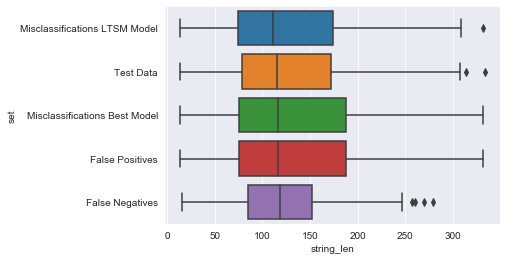

In [81]:
sns.set_style('darkgrid')
cdf = pd.concat([ltsm, test, emoji1, fp, fn], sort = False)
ax = sns.boxplot(x="string_len", y="set", data=cdf)

plt.show()

plt.clf()
plt.close()

In [64]:
import scipy
from scipy import stats

print("LTSM vs Test Set t-test:\n", stats.ttest_ind(ltsm.string_len, test.string_len))
print("\nLTSM vs Best Model t-test:\n", stats.ttest_ind(ltsm.string_len, emoji1.string_len))
print("\nBest Model vs Test Set t-test:\n", stats.ttest_ind(emoji1.string_len, test.string_len))
print("\nBecause of how small the false negative set is, we'll assume it and the false positive set have an unequal variance")
print("\nFalse Positives vs False Negatives t-test:\n", stats.ttest_ind(fp.string_len, fn.string_len, equal_var = False))


LTSM vs Test Set t-test:
 Ttest_indResult(statistic=-0.4537072875349788, pvalue=0.6500616207500612)

LTSM vs Best Model t-test:
 Ttest_indResult(statistic=-1.2110160520188802, pvalue=0.22599237609777695)

Best Model vs Test Set t-test:
 Ttest_indResult(statistic=0.9817238826866782, pvalue=0.32629089750724116)

Because of how small the false negative set is, we'll assume it and the false positive set have an unequal variance

False Positives vs False Negatives t-test:
 Ttest_indResult(statistic=0.38835154460711885, pvalue=0.6994088939776578)


<b>Doesn't seem to be anything significant here by the boxlpot visualisation or the t-test. The p value is not less than the value of 0.05 so none of these differences are not statistically significant.</b>

## Inspecting False Positives and False Negatives

In [82]:
fp = pd.read_csv('gs://csc3002/hateval2019/falsepositives.csv', sep=',', index_col = 0)
fn = pd.read_csv('gs://csc3002/hateval2019/falsenegatives.csv', sep=',', index_col = 0)

train = pd.read_csv('Raw_Data/hateval2019/hateval2019_en_train.csv', sep=',',  index_col = False, encoding = 'utf-8')
dev =  pd.read_csv('Raw_Data/hateval2019/hateval2019_en_dev.csv', sep=',',  index_col = False, encoding = 'utf-8')
frames = [train,dev]
data = pd.concat(frames)
data.rename(columns={'text': 'tweet', 'HS': 'label'}, inplace=True)
cols = ['TR', 'AG']
data.drop(cols, inplace = True, axis = 1)

print("There are", len(fn), "false negatives and ", len(fp), "false positives")
errors = len(fn) + len(fp)
print('\n{:.1f}% of errors are false positives and {:.1f}% of errors are false negatives.'.format((len(fp)/errors) *100,(len(fn)/errors) *100))

There are 47 false negatives and  1273 false positives

96.4% of errors are false positives and 3.6% of errors are false negatives.


## False Positives
Let's peek to see if there are any identifiaible trends in the data

In [83]:
fp.sample(20).head(20)

id  \
586   32359   
887   30484   
1910  34193   
192   31789   
1865  32254   
1618  31817   
386   30703   
143   33812   
987   30262   
1339  30605   
101   34240   
840   34493   
894   34464   
1326  32152   
168   30410   
1581  33502   
2311  31927   
1591  33638   
1477  33163   
1577  31545   

                                                                                                                                                                                                                                                                        tweet  \
586   user it shows that the dysfunctional party duopoly is not now nor ever has been predisposed to implement an effective program to stop the invasion rep x invasion usa user seal the border                                                                                
887   user cis this is fabulous i hope the aclu is hoist by its own petardits idiotic stupid self defeating to simply stop applying the law because there is a child involvedno other us law would do this insanity no amnesty multuser no asylum nohr392 deport daca no daca   
1910  user bitch thats literally so fucking annoying                                                                                                                                                                                                                            
192   user and they are dead wrong migrant workers are eligible to come here on visas that allow them to work to do those jobs illegal aliens need not apply                                                                                                                    
1865  user happy birthday bitch hope you have a fab day you hoe n get on lifts soon red car                                                                                                                                                                                     
1618  i truly shouldve blocked carter when this bitch said orange juice and grape juice better than apple juice                                                                                                                                                                 
386   multuser all glory to a pair of con artists who spent eight years working for their billionaire buddies walk away march nra ice build that wall veterans                                                                                                                  
143   user rapefugee is offensive please use the term consentually challenged                                                                                                                                                                                                   
987   multuser only 9 thats shameful it should be 900 no amnesty no daca                                                                                                                                                                                                        
1339  multuser acevedo yay live in michoacan mexico where police are blindfolded and dump in the streets dead with notes on there body taughting the police build that wall                                                                                                     
101   illegal entry into the us is a crime and the democrats have set up welfare systems that reward them for breaking the law entering illegally with benefits welfare and voting rights build the wall now stop immigration until the laws get fitted                         
840   17 year old charged in killing of teenager in annapolis linked to ms 13 no amnesty no daca deport them all multuser these are not anomalies this is becoming the normimmigration reform does not entail giving a free pass                                                
894   multuser one mans conspiracy is another mans truth buy from in and out internet bill of rights dark left walk away reinstate robyn gritz j

### We can refine the dataframe by only returning tweets with certains words/phrase

In [84]:
def searchDataWithTerms(df, words):
    if words != []:
        temp_set =pd.DataFrame()
        for word in words:
            temp = df[df.tweet.str.contains(word)]
            print(len(temp), "tweets containing", word)
            temp_set = pd.concat([temp, temp_set], axis = 0)
    return temp_set

words = ["send them back", "send them home"]
#fp.drop(['Unnamed: 0', 'set', 'string_len'], axis = 1, inplace =True)
tweets = searchDataWithTerms(fp, words)
tweets.sample(20)

35 tweets containing send them back
7 tweets containing send them home


id  \
1388  30226   
827   34379   
767   33793   
771   30660   
30    31770   
818   33558   
125   34570   
756   30109   
811   31720   
773   31100   
798   30236   
867   30415   
765   30895   
45    31548   
78    34182   
776   30068   
779   31693   
92    33771   
828   34393   
755   31648   

                                                                                                                                                                                                                                                              tweet  \
1388  multuser toronto is starting to sound like londonstanwe have to get on the madmax2019 trainuser is the only one who can get our country back ban muslims ban islam send them back                                                                               
827   multuser send them back i will contribute to the plane fare no joke                                                                                                                                                                                             
767   multuser bit wishy washy policy tho send them back                                                                                                                                                                                                              
771   user no we wouldnt liberalism is a mental disorder walk away user trump2020 maga america first red rage drain the swamp build the wall send them back boycott hollywood boycott the nfl fake news                                                               
30    just as scuzball democrats want need build the wall send them home                                                                                                                                                                                              
818   user kaysen user well then that would be one less woman affected if he werent here illegally send them back                                                                                                                                                     
125   multuser kick turkey out of user kick the user out of the united states now build the wall send them back drain the swamp trump2020 maga america first term limits                                                                                              
756   africans having their say about blacks in europe and europeans in africa at the land expropriation hearings currently underway in south africa send them back                                                                                                   
811   multuser allenk im thinking that myself how did it come to this and why america first close the border wide awake send them back                                                                                                                                
773   legal immigrant running for house crushes every single objection to trumps wall send them back no amnesty build the wall end chain migration end the visa lottery end anchor babies no daca                                                                     
798   user more than 200000 young illegals overcrowding us schools getting free school lunch breakfast food stamps and medicaid send them back at the border and stop the scam trump maga red nat in rising user                                                      
867   user i hope you are not offering them a choice to hell with the tories send them home                                                                                                                                                                           
765   user has the legal right to end obamas illegal daca memo congress did not pass daca three times end it now red nation rising trump maga no daca no amnesty send them home with their illegal parents stop rewarding illegals user                               
45    a lit

## False Negatives

In [76]:
#fn.drop(['set', 'string_len'], axis = 1, inplace =True)
fn.sample(20)

id  \
16  33715   
28  32066   
32  30878   
12  33430   
34  32716   
8   30844   
35  30950   
29  30721   
7   32754   
44  32220   
30  31587   
36  31600   
33  32191   
26  30970   
27  30852   
4   30599   
9   30542   
20  33256   
45  30104   
22  30160   

                                                                                                                                                                                                                                                                            tweet  \
16  user stopimmigration                                                                                                                                                                                                                                                            
28  on me ima have this bitch blasted i had enough of this bullshit i hate crying cuz i have to hold in the urge to kill an old cunt                                                                                                                                                
32  dumb cunt ass cheating bitch doesnt deserve shit in this world but herpes multiple slightly smiling face                                                                                                                                                                        
12  bitch i clearly realized that already look at my name dumb cunt                                                                                                                                                                                                                 
34  new olympic sport illegal migrant stowaways jump lorry illegal immigration boris johnson                                                                                                                                                                                        
8   bitch whore son of bitch shit pig dinosaur elephant rhino monkey dog                                                                                                                                                                                                            
35  user sea tow the boat back to the safe ports in africa send them back its not late to save europe not wanted not needed                                                                                                                                                         
29  hoes be like happy birthday son i cant believe your 8 already like what you cant believe bitch you had him in high school                                                                                                                                                       
7   navy rescued manchester bomber salman abedi from war torn libya three years before deadly terror attack via user west is rescuing people that will kill them send them home bombing attack have some dignity and throw them out                                                 
44  user republicans in congress dont want to see another republican impeached multuser on secret recording said this all goes away if the republicans dont keep the house nunes tape shows plot to fire rosenstein vote blue no matter who send them home                          
30  the us is 21 trillion in debt we cant import the poor and give them welfare trump maga send them back immigration red nation rising via user                                                                                                                                    
36  why am i no longer shocked when i read about the brutality of women from those that europe attempts to help send them back                                                                                                                                                      
33  user contemplate no youre semi woke1 firang hatred for gypsies us a fact2 any anti firang force even the jihadi rapefugee hordes